<h1 id="tocheading">Variational Autoencoder for IllustriTNG Neutral Hydrogen Distribution</h1>
<div id="toc"></div>

In [172]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [173]:
! pip install sklearn

In [174]:
! pip install Cython

In [175]:
! git clone https://github.com/franciscovillaescusa/Pylians

fatal: destination path 'Pylians' already exists and is not an empty directory.


In [176]:
! cd Pylians/library/ python setup.py build

In [177]:
# from Pylians.library import Pk_library
# import Pylians as PKL
# from Pylians.library import Pk

In [178]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [179]:
%load_ext cythonmagic

The cythonmagic extension is already loaded. To reload it, use:
  %reload_ext cythonmagic


In [180]:
## model 
from __future__ import print_function
import argparse
import numpy as np
import os
import h5py
import pickle as pkl
import random
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
from torch.distributions import normal

## plot
import itertools
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import h5py
import matplotlib as mpl
import pyfftw
import Pk_library as PKL

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [181]:
## sampling from normal
m = normal.Normal(0.2,0.3)
m.sample()

tensor(0.1494)

In [182]:
m.sample((2,3))

tensor([[-0.2959,  0.4922,  0.8558],
        [ 0.5764,  0.4175, -0.2682]])

In [183]:
tuple([(3)]*3)

(3, 3, 3)

In [184]:
def collapse_cube(cube, dim):
    """Takes as input:
    : cube: the transformed or original cube sample (3d array) 
            to collapse into 2d (square),
            we will compare those with the 2d output of the VAE.
    : dim: int dimension of the cube to use for (0,1,2)
           collapsing i.e. 0 = 'x', 1 = 'y' or 2 = 'z'
    
    Returns:
    : collapsed (sum) sample in 2d"""
    
    if type(cube) == np.ndarray:
        collapsed_cube = np.sum(cube, dim)
    else:
        collapsed_cube = torch.sum(cube, dim)
        
    return collapsed_cube

def fix_gaussian_noise(size, dim):
    # To be used ONCE before starting training and validation
    """Takes as input:
    : size: the integer length of each dimension,
    : dim: 2 or 3, indicating square or cube,
    
    Returns: 
    : Torch tensor Gaussian noise of size 'size', 2x2 or 3x3"""
        
    # mu = 0, std = 1, assuming the ground truth is 
    # standardized
    nrm = normal.Normal(0,1)
    noise = nrm.sample(tuple([(size)]*dim))
    
    return noise

In [185]:
# collapse_cube(A, 1)

In [186]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """Function for dividing/truncating cmaps"""
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def visualize_cube(cube=None,      ## array name
             edge_dim=None,        ## edge dimension (128 for 128 x 128 x 128 cube)
             start_cube_index_x=0,
             start_cube_index_y=0,
             start_cube_index_z=0,
             fig_size=None,
             norm_multiply=600,
             color_map="Blues",
             lognormal=False):
    
    """Takes as input;
    - cube: A 3d numpy array to visualize,
    - edge_dim: edge length,
    - fig_size: Figure size for the plot,
    - norm_multiply: Multiplication factor to enable matplotlib to 'see' the particles,
    - color_map: A maplotlib colormap of your choice,
    - lognormal: Whether to apply lognormal transformation or not. False by default.
    
    Returns: 
    - The cube visualization"""
    
    ## plot all the cubes in the batch
    
    # pdf's - original and regenerated
    
    # cube visuals
    
    # power spectrum
    
    
    cube_size = edge_dim
    edge = np.array([*range(cube_size)])
    
    end_x = start_cube_index_x + cube_size
    end_y = start_cube_index_y + cube_size
    end_z = start_cube_index_z + cube_size
    
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111, projection='3d')
    
    data_value = cube[start_cube_index_x:end_x,
                      start_cube_index_y:end_y,
                      start_cube_index_z:end_z]
    
    x,y,z = edge,edge,edge
    product = [*itertools.product(x,y,z)]
    
    X = np.array([product[k][0] for k in [*range(len(product))]])
    Y = np.array([product[k][1] for k in [*range(len(product))]])
    Z = np.array([product[k][2] for k in [*range(len(product))]])
    
    ## map data to 1d array that corresponds to the axis values in the product array
    data_1dim = np.array([data_value[X[i]][Y[i]][Z[i]] for i in [*range(len(product))]])
    
    
#     initial_mean = np.mean(data_1dim) - stdev_to_white*np.std(data_1dim)
#     mask = data_1dim > initial_mean
#     mask = mask.astype(np.int)
    
#     data_1dim = np.multiply(mask,data_1dim)
    ## mask X,Y,Z to match the dimensions of the data
    X, Y, Z, data_1dim = [axis[np.where(data_1dim>0)] for axis in [X,Y,Z,data_1dim]]

    if lognormal == False:
        s = norm_multiply*data_1dim/np.linalg.norm(data_1dim)
    else:
        s = np.log(norm_multiply*data_1dim/np.linalg.norm(data_1dim))
    
    cmap=plt.get_cmap(color_map)
    new_cmap = truncate_colormap(cmap, 0.99, 1,n=10)
    
    ## IGNORE BELOW 3D PLOT FORMATTING 
    
    ## plot cube
    
    cube_definition = [(start_cube_index_x, start_cube_index_x, start_cube_index_x),
                      (start_cube_index_x, start_cube_index_x+edge_dim, start_cube_index_x),
                      (start_cube_index_x+edge_dim, start_cube_index_x, start_cube_index_x),
                      (start_cube_index_x, start_cube_index_x, start_cube_index_x+edge_dim)]
    
    cube_definition_array = [
        np.array(list(item))
        for item in cube_definition
    ]
    
    
    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]
    
    
    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

    points = np.array(points)

    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]
    
#     ax.fig.add_subplot(111, projection='3d')
    
    faces = Poly3DCollection(edges, linewidths=1, edgecolors='k',)
    faces.set_facecolor((0,0,1,0)) ## set transparent facecolor to the cube
    
    ax.add_collection3d(faces)
    
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0)

    ax.set_aspect('equal')
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    
    ax.xaxis.set_major_locator(MultipleLocator(edge_dim))
    ax.yaxis.set_major_locator(MultipleLocator(edge_dim))
    ax.zaxis.set_major_locator(MultipleLocator(edge_dim))
    
    ax.grid(False)
    
    ax.set_xlim3d(0,edge_dim)
    ax.set_ylim3d(0,edge_dim)
    ax.set_zlim3d(0,edge_dim)
#     ax.get_frame_on()
    
    ax.xaxis._axinfo['tick']['inward_factor'] = 0
    ax.xaxis._axinfo['tick']['outward_factor'] = 0
    ax.yaxis._axinfo['tick']['inward_factor'] = 0
    ax.yaxis._axinfo['tick']['outward_factor'] = 0
    ax.zaxis._axinfo['tick']['inward_factor'] = 0
    ax.zaxis._axinfo['tick']['outward_factor'] = 0
    
    ax.scatter(X, Y, Z,       ## axis vals
               c=data_1dim,   ## data, mapped to 1-dim
               cmap=new_cmap,
               s=s,           ## sizes - dims multiplied by each data point's magnitude
               alpha=0.7,
               edgecolors="face")
    
    
    
    plt.show()

In [187]:
datapath=''
redshift = '0.0'
f = h5py.File("minmax_scale_01_redshift1.h5", 'r')
# f = h5py.File("iqr_shift_redshift_0.0.h5", 'r')
# f=f['delta_HI']

def cube_mass_histogram(cube=None,      ## array name
             edge_dim=128,        ## edge dimension (128 for 128 x 128 x 128 cube)
             start_cube_index_x=0,
             start_cube_index_y=0,
             start_cube_index_z=0,
             fig_size=(20,10),
             stdev_to_white=1,
             norm_multiply=1,
             color_map="Blues",
             lognormal=False,
             hist_color="b",
                       hist_bins=300,
                       xlim=None):
    
    ## adjust cube and get 1d array of in-cube masses
    cube_size = edge_dim
    edge = np.array([*range(cube_size)])
    
    end_x = start_cube_index_x + cube_size
    end_y = start_cube_index_y + cube_size
    end_z = start_cube_index_z + cube_size
    
    data_value = cube[start_cube_index_x:end_x,
                      start_cube_index_y:end_y,
                      start_cube_index_z:end_z]
    
    x,y,z = edge,edge,edge
    product = [*itertools.product(x,y,z)]
    
    X = np.array([product[k][0] for k in [*range(len(product))]])
    Y = np.array([product[k][1] for k in [*range(len(product))]])
    Z = np.array([product[k][2] for k in [*range(len(product))]])
    
    ## map data to 1d array that corresponds to the axis values in the product array
    data_1dim = np.array([data_value[X[i]][Y[i]][Z[i]] for i in [*range(len(product))]])
    
    ## start plotting
    plt.figure(figsize=fig_size)
    plt.hist(data_1dim,bins=hist_bins,
            alpha=0.4)
    
    if xlim != None:
        plt.xlim(xlim[0],xlim[1])
    else:
        plt.xlim(None)
        
    plt.xlabel("Masses")
    plt.ylabel("Number of Samples That Correspond to the Mass")
    plt.title("Output Mass Histogram")
    plt.show()

In [17]:
# modify to accept hard coded arguments
# batch_size = 8
batch_size = 16
# batch_size = 32
epochs = 100
no_cuda = False
log_interval = 1

cuda = not no_cuda and torch.cuda.is_available()
# cuda = True

seed = 1
torch.manual_seed(seed)


# device = torch.device("cuda" if args.cuda else "cpu")
device = torch.device("cuda" if cuda else "cpu")

# kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [18]:
scaler = StandardScaler()

In [19]:
def define_test(s_test, s_train):
    #2048/16=128
    m=8
    x=random.randint(0,m)*s_train
    y=random.randint(0,m)*s_train
    z=random.randint(0,m)*s_train
    #print(x,y,z)
    return {'x':[x,x+s_test], 'y':[y,y+s_test], 'z':[z,z+s_test]}

def check_coords(test_coords, train_coords):
    valid=True
    for i in ['x','y','z']:
        r=(max(test_coords[i][0], 
               train_coords[i][0]), 
           min(test_coords[i][1],
               train_coords[i][1]))
        if r[0]<=r[1]:
            valid=False
    return valid

# def get_samples(datapath, s_sample, nsamples, redshift, test_coords):
#     #n is size of minibatch, get valid samples (not intersecting with test_coords)
#     sample_list=[]
#     m=2048-128
#     for n in range(nsamples):
#         #print("Sample No = " + str(n + 1) + " / " + str(nsamples))
#         sample_valid=False
#         while sample_valid==False:
#             x = random.randint(0,m)
#             y = random.randint(0,m)
#             z = random.randint(0,m)
#             sample_coords = {'x':[x,x+s_sample], 
#                              'y':[y,y+s_sample], 
#                              'z':[z,z+s_sample]}
            
#             sample_valid = check_coords(test_coords, sample_coords)
        
#         sample_list.append(sample_coords)
    
#     #print("Sampling finished.")
        
#     #Load cube and get samples and convert them to np.arrays
#     sample_array=[]
#     #datapath='../../../../../'
#     #f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
#     #f=f['delta_HI']
    
#     counter = 0
#     for c in sample_list:
#         #if counter%100==0:
#         #    print("Counter = " + str(counter + 1) + " / " + str(len(sample_list)))
#         a = f[c['x'][0]:c['x'][1],
#               c['y'][0]:c['y'][1],
#               c['z'][0]:c['z'][1]]
        
#         #a = np.array(a)
#         a = np.array(a)
#         sample_array.append(a)
    
#         counter = counter + 1
        
    
#     return sample_array



## OLD
def get_samples(filepath, s_sample, nsamples, test_coords):
    #n is size of minibatch, get valid samples (not intersecting with test_coords)
    sample_list=[]
    m=2048-128
    for n in range(nsamples):
        #print("Sample No = " + str(n + 1) + " / " + str(nsamples))
        sample_valid=False
        while sample_valid==False:
            x = random.randint(0,m)
            y = random.randint(0,m)
            z = random.randint(0,m)
            sample_coords = {'x':[x,x+s_sample], 
                             'y':[y,y+s_sample], 
                             'z':[z,z+s_sample]}
            
            sample_valid = check_coords(test_coords, 
                                        sample_coords)
        
        sample_list.append(sample_coords)
    
    print("Sampling finished.")
        
    #Load cube and get samples and convert them to np.arrays
    sample_array=[]
    datapath=''
    f = h5py.File(filepath, 'r')
#     f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
    f=f['delta_HI']
#     f = scaler.fit_transform(np.array(f))
    
    # getting the max of the whole cube
    #print(f.shape)
    max_list = []
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        max_list.append(np.max(f[i:i+1,:,:]))
    max_cube = max(max_list)
    #f.close()
    
    print("Getting max value finished.")
    
    counter = 0
    for c in sample_list:
        print("Counter = " + str(counter + 1) + " / " + str(len(sample_list)))
        a = f[c['x'][0]:c['x'][1],
              c['y'][0]:c['y'][1],
              c['z'][0]:c['z'][1]]
        
        # a = np.array(a)
        ### datayi -1 1 arasina almayi dene
        
#         a = np.array(a) / max_cube
#         a = np.array([scaler.fit_transform(np.array(x)) for x in a])
#         a = (a - np.mean(a)*np.ones(a.shape))/np.std(a)
#         a = 
        a = np.array(a)/max_cube
        a = a + 1
        a = np.log(a)

        sample_array.append(a)

        counter = counter + 1
        
    f=0
    sample_array = np.array(sample_array)
    return sample_array

In [20]:
# class HydrogenDataset(Dataset):
#     """Hydrogen Dataset"""

#     def __init__(self, root_dir, s_test, s_sample, nsamples, redshift, transform):
#         """
#         Args:
#             h5_file (string): name of the h5 file with 32 sampled cubes.
#             root_dir (string): Directory with the .h5 file.
#         """
#         #file_size = os.path.getsize(root_dir + h5_file) / 1e6 # in MBs
#         #print("The whole file size is " + str(int(file_size)) + " MBs")
        
#         # self.subcubes = h5py.File('../data/sample_32.h5', 'r')
#         self.root_dir = root_dir
#         self.s_test = s_test
#         self.s_sample = s_sample
#         self.t_coords = define_test(self.s_test,self.s_sample)
#         self.nsamples = nsamples
#         self.redshift = redshift
#         self.transform = transform
#         self.filepath = filepath
#         if self.transform == 'max':
#             self.max_cube=get_max_cube(self.root_dir, self.redshift)
#        # if self.transform=='normalize':
#         #    self.mean=
#          #   self.std=

#     def __len__(self):
#         # Function called when len(self) is executed
#         return self.nsamples

#     def __getitem__(self, idx):
#         """
#         This can be implemented in such a way that the whole h5 file read 
#         using h5py.File() and get_sample() function is called to return
#         a random subcube. This won't increase memory usage because the
#         subcubes will be read in the same way and only the batch will
#         be read into memory.
        
#         Here we have implemented it so that it can be used with data
#         generated by get_sample() function.
        
#         The output of this function is one subcube with the dimensions
#         specified by get_sample() implementation.
#         """
        
#         sample = get_samples(filepath=self.filepath,
#                             s_sample = self.s_sample,
#                              nsamples = 1,
#                              test_coords = self.t_coords)
        
#         if self.transform=='max':
#             sample = sample / np.array(self).max_cube
#         if self.transform=='normalize':
#             sample = (np.array(sample)-np.array(self).mean)/np.array(self).std
    
#         sample=np.array(sample).reshape((1,self.s_sample,self.s_sample,self.s_sample))

#         return sample

In [21]:
def get_statistics(datapath, redshift):
    f_ = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
    f=f_['delta_HI']
    
    max_list, min_list, mean_list, variance_list= [], [], [], []
   
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        max_list.append(np.max(f[i:i+1,:,:]))
        min_list.append(np.min(f[i:i+1,:,:]))
        mean_list.append(np.mean(f[i:i+1,:,:]))
        #variance_list.append(np.mean(np.square(f[i:i+1,:,:] - mean_cube)))
    #mean_cube = np.mean(mean_list)
    #for i in range(f.shape[0]):
    
    f.close()
    
    max_cube = max(max_list)
    min_cube = min(min_list)
    mean_cube = np.mean(mean_list)
    #stddev_cube = np.sqrt(np.mean(variance_list))
    return max_cube, min_cube, mean_cube
    

def get_max_cube(datapath, redshift):
    f= h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
    f=f['delta_HI']
    max_list = []
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        max_list.append(np.max(f[i:i+1,:,:]))
    max_cube = max(max_list)
   
    return max_cube

def get_min_cube(datapath, redshift):
    min_list = []
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        min_list.append(np.min(f[i:i+1,:,:]))
    min_cube = min(min_list)
    return min_cube

def get_mean_cube(datapath, redshift):
    mean_list = []
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        mean_list.append(np.mean(f[i:i+1,:,:]))
    mean_cube = np.mean(mean_list)
    return mean_cube

def get_stddev_cube(datapath, redshift, mean_cube):
    variance_list = []
    for i in range(f.shape[0]):
        variance_list.append(np.mean(np.square(f[i:i+1,:,:] - mean_cube)))
    stddev_cube = np.sqrt(np.mean(variance_list))
    return stddev_cube

In [22]:
t_coords=define_test(1024,128)

In [23]:
class HydrogenDataset2(Dataset):
    """Hydrogen Dataset"""

    def __init__(self, filepath,h5_file, root_dir, s_test, s_train,
                 s_sample, nsamples, redshift):
        """
        Args:
            h5_file (string): name of the h5 file with 32 sampled cubes.
            root_dir (string): Directory with the .h5 file.
        """
        file_size = os.path.getsize(root_dir + h5_file) / 1e6 # in MBs
        print("The whole file size is " + str(int(file_size)) + " MBs")
        
        # self.subcubes = h5py.File('../data/sample_32.h5', 'r')
        self.subcubes = h5py.File(root_dir + h5_file, 'r')["delta_HI"]
        self.h5_file = h5_file
        self.root_dir = root_dir
        self.s_test = s_test
        self.s_train = s_train
        self.t_coords = define_test(self.s_test,
                                    self.s_train)
        self.s_sample = s_sample
        self.nsamples = nsamples
        self.redshift = redshift, 
        self.filepath = filepath
        
        self.samples = get_samples(filepath = self.filepath, s_sample =self.s_sample,
                             nsamples = self.nsamples,
                             test_coords = self.t_coords)

    def __len__(self):
        # Function called when len(self) is executed
        
        #print(len(self.subcubes))
#         return len(self.nsamples)
        return self.nsamples

    def __getitem__(self, idx):
        """
        This can be implemented in such a way that the whole h5 file read 
        using h5py.File() and get_sample() function is called to return
        a random subcube. This won't increase memory usage because the
        subcubes will be read in the same way and only the batch will
        be read into memory.
        
        Here we have implemented it so that it can be used with data
        generated by get_sample() function.
        
        The output of this function is one subcube with the dimensions
        specified by get_sample() implementation.
        """
        
        # default version -> error in training because of dimensions
#         sample = self.subcubes[idx]
        
        # reshaped version to add another dimension
#         sample = self.subcubes[idx].reshape((1,128,128,128))

        # On prince using get_samples()
#         print("nsamples = " + str(self.nsamples))
#         sample = get_samples(s_sample = self.s_sample,
#                              nsamples = self.nsamples,
#                              redshift = self.redshift,
#                              test_coords = self.t_coords)
        
        sample = np.array(self.samples[idx].reshape((1,128,128,128)))
        mask = (sample > 1e-25)
        mask = mask.astype(np.float)
        # shift sample
        sample = np.multiply(sample,mask)
        sample = torch.FloatTensor(sample)
        # added division by 1e6 for exploding variance
        # and resulting in inf during reparametrization trick part
#         sample = sample/1e6
        
        ##3 normalize here 
        
#         sample = sample/1e6
        
        return sample

In [24]:
# #  Transform: Min-Max 0-1
# sampled_subcubes = HydrogenDataset2(h5_file="minmax_scale_01_redshift1.h5", #"fields_z=1.0.hdf5",
#                                     root_dir = "",
#                                     s_test = 1024, 
#                                     s_train = 128,
#                                     s_sample = 128, 
#                                     nsamples = 256, 
#                                     redshift = "1.0",
#                                     filepath="minmax_scale_01_redshift1.h5")

### Root Transform

In [25]:
datapath=''
redshift = '1.0'
f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
f=f['delta_HI']

# max_cube = get_max_cube(datapath, redshift)
# median_cube = get_median_cube(datapath, redshift)

In [26]:
# print (max_cube)

In [27]:
max_cube = 18153447000.0

In [28]:
# min_cube = get_min_cube(datapath, redshift)
# stddev_cube = get_stddev_cube(f = f, mean_cube = mean_cube)

In [29]:
# print (min_cube)

In [30]:
min_cube = 0.0

In [31]:
# mean_cube = get_mean_cube(datapath, redshift)

In [32]:
# print (mean_cube_cube_cube)

In [33]:
mean_cube = 10170.682

In [34]:
# stdev_cube = get_stddev_cube(datapath, redshift, mean_cube)

In [35]:
# stdev_cube

In [36]:
stdev_cube = 3474200.8

In [37]:
def sqrt_transform(f_sample=f,
                   inverse = "False",
                mean_cube = mean_cube,
                stddev_cube = stdev_cube,
                shift = "True",
                shift_magnitude=0,
                degree_of_sqrt=16, 
                redshift = "1.0",
                save_or_return = True):
    """
    save_or_return = True for save, False for return
    """
    whole_new_f = np.empty(shape = (f_sample.shape[0],
                                    f_sample.shape[1],
                                    f_sample.shape[2]),
                       dtype = np.float64)
    
    print("whole_new_f shape = "+ str(whole_new_f.shape))
    
    if inverse == False:
        for i in range(f_sample.shape[0]):
            print(str(i + 1) + " / " + str(f_sample.shape[0])) if i % 250 == 0 else False
            if shift:
                shift_magnitude = shift_magnitude
                whole_new_f[i:i+1,:,:] = np.power(f_sample[i:i+1,:,:] + shift_magnitude, 
                                                       1/degree_of_sqrt)
            else:
                whole_new_f[i:i+1,:,:] = np.power(f_sample[i:i+1,:,:], 
                                                       1/degree_of_sqrt)
            
#         print("New mean = " + str(np.mean(whole_new_f)))
#         print("New median = " + str(np.median(whole_new_f)))
#         print("New min = " + str(np.amin(whole_new_f)))
#         print("New max = " + str(np.amax(whole_new_f)))
        
    elif inverse == True:
        for i in range(f_sample.shape[0]):
            print(str(i + 1) + " / " + str(f_sample.shape[0])) if i % 250 == 0 else False
            if shift:
                shift_magnitude = shift_magnitude
                inverse_transform_f[i:i+1,:,:] = np.power(f_sample[i:i+1,:,:],degree_of_sqrt) - shift_magnitude
            else:
                inverse_transform_f[i:i+1,:,:] = np.power(f_sample[i:i+1,:,:],degree_of_sqrt)
        
    else:
        raise Exception('Please specify whether you want normal or inverse scaling!')
    
    
    if save_or_return and inverse == False:
        if shift:
            hf = h5py.File('new8_sqrt_shift_redshift_'+redshift+'.h5', 'w')
        else:
            hf = h5py.File('new8_sqrt_noshift_redshift_'+redshift+'.h5', 'w')
        hf.create_dataset('delta_HI', data=whole_new_f)
        hf.close()
    elif save_or_return and inverse == True:
        raise Exception('Why do you want to save the inverse transformed?\nIts the normal one!')
    else:
        return whole_new_f

In [38]:
root16 = sqrt_transform(f_sample=f,
                   inverse = False,
                mean_cube = mean_cube,
                stddev_cube = stdev_cube,
                shift = True,
                shift_magnitude=0,
                degree_of_sqrt=8, 
                redshift = "1.0",
                save_or_return = True)

whole_new_f shape = (2048, 2048, 2048)
1 / 2048
251 / 2048
501 / 2048
751 / 2048
1001 / 2048
1251 / 2048
1501 / 2048
1751 / 2048
2001 / 2048


In [115]:
sampled_subcubes = HydrogenDataset2(h5_file="new10_sqrt_shift_redshift_1.0.h5", #"fields_z=1.0.hdf5",
                                    root_dir = "",
                                    s_test = 1024, 
                                    s_train = 128,
                                    s_sample = 128, 
                                    nsamples = 256, 
                                    redshift = "1.0",
                                    filepath="new10_sqrt_shift_redshift_1.0.h5")

The whole file size is 68719 MBs
Sampling finished.
Getting max value finished.
Counter = 1 / 256
Counter = 2 / 256
Counter = 3 / 256
Counter = 4 / 256
Counter = 5 / 256
Counter = 6 / 256
Counter = 7 / 256
Counter = 8 / 256
Counter = 9 / 256
Counter = 10 / 256
Counter = 11 / 256
Counter = 12 / 256
Counter = 13 / 256
Counter = 14 / 256
Counter = 15 / 256
Counter = 16 / 256
Counter = 17 / 256
Counter = 18 / 256
Counter = 19 / 256
Counter = 20 / 256
Counter = 21 / 256
Counter = 22 / 256
Counter = 23 / 256
Counter = 24 / 256
Counter = 25 / 256
Counter = 26 / 256
Counter = 27 / 256
Counter = 28 / 256
Counter = 29 / 256
Counter = 30 / 256
Counter = 31 / 256
Counter = 32 / 256
Counter = 33 / 256
Counter = 34 / 256
Counter = 35 / 256
Counter = 36 / 256
Counter = 37 / 256
Counter = 38 / 256
Counter = 39 / 256
Counter = 40 / 256
Counter = 41 / 256
Counter = 42 / 256
Counter = 43 / 256
Counter = 44 / 256
Counter = 45 / 256
Counter = 46 / 256
Counter = 47 / 256
Counter = 48 / 256
Counter = 49 / 25

In [116]:
def inverse_sqrt(transformed_cube, shift, power):
    """Takes as input a squareroot transformed and shifted
    cube, the shift amount, and the degree (power) of transformation.
    Reverts the transformation,
    
    Returns the original cube"""
    
    inverse_transform_f = np.empty(shape=(transform_sample.shape[0],
                                     transform_sample.shape[1],
                                     transform_sample.shape[2]),
                              dtype=np.float64)
    
    s = shift

    for i in range(transformed_cube.shape[0]):
        inverse_transform_f[i:i+1,:,:] = np.power(transformed_cube[i:i+1,:,:],power) - s
        
    return inverse_transform_f


In [117]:
type(sampled_subcubes)

__main__.HydrogenDataset2

In [118]:
# [*sampled_subcubes][0][:5,:5,:5]

In [119]:
np.mean(np.array(sampled_subcubes[1]))

0.07170271

In [120]:
np.std(np.array(sampled_subcubes[1]))

0.040519

In [121]:
np.min(np.array(sampled_subcubes[1]))

0.0

In [122]:
np.max(np.array(sampled_subcubes[1]))

0.6637009

In [123]:
# np.save("my_HI_field.npy",sampled_subcubes[1])

In [124]:
# ! ls Pylians/library/Pk_library/

In [125]:
# import Pylians as PKL
# from Pylians.PKL import Pk

# ## example Pylians

# delta = np.load("my_HI_field.npy")
# delta /= np.mean(delta, dtype=np.float64)  
# delta -= 1.0
# delta = delta.astype(np.float32)

# BoxSize = 75.0/2048*128
# axis=0
# MAS="CIC"
# threads=1

# Pk = PKL.Pk(delta, BoxSize, axis, MAS, threads)

# np.savetxt("my_Pk.txt", np.transpose([Pk.k3D, Pk.Pk[:,0]]))

In [126]:
# sampled_subcubes[1]

In [127]:
# Data Loaders
train_loader = DataLoader(
        dataset=sampled_subcubes,
        #batch_size=args.batch_size, 
        batch_size=batch_size,
        shuffle=True, 
        **kwargs)

test_loader = DataLoader(
        dataset=sampled_subcubes,
        #batch_size=args.batch_size, 
        batch_size=batch_size,
        shuffle=True, 
        **kwargs)

## VAE

The original skeleton is taken and modified from the below sources:

- Pytorch's Basic VAE example at https://github.com/pytorch/examples/tree/master/vae 
- bhpfelix's Vanilla VAE: https://github.com/3ammor/Variational-Autoencoder-pytorch/blob/master/graph/mse_model.py 

In [244]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        
        # PARAMETER CHEATSHEET
        # Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # BatchNorm2d(out_channels)
        # Linear(in_features, out_features)
        
        # ENCODER Layers
        
        self.conv1 = nn.Conv2d(1, 8, 4, 2, 1)
        nn.init.xavier_uniform_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Conv2d(8, 16, 4, 2, 1)
        nn.init.xavier_uniform_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(16, 32, 4, 2, 1)
        nn.init.xavier_uniform_(self.conv3.weight)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.fc1 = nn.Linear(2048, 128)
        self.fc1_dropout = nn.Dropout2d(0.1)
        nn.init.xavier_uniform_(self.fc1.weight)
        
        self.fc2 = nn.Linear(128, 128)
        self.fc2_dropout = nn.Dropout2d(0.1)
        nn.init.xavier_uniform_(self.fc2.weight)
        
        self.fc31 = nn.Linear(128, 16)
        self.fc31_dropout = nn.Dropout2d(0.1)
        nn.init.xavier_uniform_(self.fc31.weight)
        
        self.fc32 = nn.Linear(128, 16)
        self.fc32_dropout = nn.Dropout2d(0.1)
        nn.init.xavier_uniform_(self.fc32.weight)

        # DECODER Layers
        
        self.fc4 = nn.Linear(16, 128)
        
        
        # First Fully Connected Layer
        self.decode_fc1 = nn.Sequential(
            nn.Linear(in_features=16,
                      out_features=128))
        
        # Second Fully Connected Layer
        self.decode_fc2 = nn.Sequential(
            nn.Linear(in_features=128, 
                      out_features=128), 
            nn.ReLU(),
            nn.Dropout(0.3))
        
        # Third Fully Connected Layer
        self.decode_fc3 = nn.Sequential(
            nn.Linear(in_features = 128,
                      out_features = 2048),
            nn.ReLU(),
            nn.Dropout(0.3))
        
        # Convolutional Layer 1
        self.decode_conv1 = nn.ConvTranspose3d(in_channels=32, 
                                              out_channels=16, 
                                              kernel_size=(4,4,4),
                                              stride = (2,2,2),
                                              padding=(1,1,1))
        self.decode_relu1 = nn.ReLU()
        self.decode_maxunpool1 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), 
                                                     stride=(2, 2, 2))
        
        # Convolutional Layer 2
        self.decode_conv2 = nn.ConvTranspose3d(in_channels=16, 
                                              out_channels=8, 
                                              kernel_size=(4,4,4),
                                              stride = (2,2,2),
                                              padding=(1,1,1))
        self.decode_relu2 = nn.ReLU()
        self.decode_maxunpool2 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), 
                                                     stride=(2, 2, 2))
        # Convolutional Layer 3
        self.decode_conv3 = nn.ConvTranspose3d(in_channels=8, 
                                              out_channels=1, 
                                              kernel_size=(4,4,4),
                                              stride = (2,2,2),
                                              padding=(1,1,1))
        self.decode_relu3 = nn.ReLU()
        self.decode_maxunpool3 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), 
                                                     stride=(2, 2, 2))
        
        ## initialize out lists 
        self.first_decode_out_sum = []
        self.conv_1_out_sum = []
        self.relu_1_out_sum = []
        self.max_unpool_1_out_sum = []
        self.conv_2_out_sum = []
        self.relu_2_out_sum = []
        self.max_unpool_2_out_sum = []
        self.conv_3_out_sum = []
        self.relu_3_out_sum = []
        
        self.decode_softmax = nn.Softmax()
        
        
        # Encoding part of VAE
    def encode(self, x):
#         h1 = F.relu(self.fc1(x))
#         return self.fc21(h1), self.fc22(h1)

        print("Starting Encoding")
#         print("----------------------------")
        
        out = self.encode_conv1(x)
#         print("First Conv output shape = " + str(out.shape))
        #print(out.shape)
        out = self.encode_relu1(out)
        out = self.bn1(out)
#         print("First ReLU Layer output shape = " + str(out.shape))
        size1 = out.size()
        out, ind1 = self.encode_maxpool1(out)
#         print("First MaxPooling output shape = " + str(out.shape))
#         print("Ind1 shape = " + str(ind1.shape))
#         #print("Size1 = " + str(size1))
#         print("----------------------------")
        
        out = self.encode_conv2(out)
#         print("Second Conv output shape = " + str(out.shape))
        out = self.encode_relu2(out)
        out = self.bn2(out)
#         print("Second ReLU Layer output shape = " + str(out.shape))
        size2 = out.size()
        out, ind2 = self.encode_maxpool2(out)
#         print("Second MaxPooling output shape = " + str(out.shape))
#         print("Ind2 shape = " + str(ind2.shape))
        #print("Size2 = " + str(size2))
#          print("----------------------------")
        
        out = self.encode_conv3(out)
#         print("Last Conv output shape = " + str(out.shape))
        out = self.encode_relu3(out)
        out = self.bn3(out)
#         print("Last ReLU output shape = " + str(out.shape))
        size3 = out.size()
#         out, ind3 = self.encode_maxpool3(out)
#         print("Last Conv Layer output shape = " + str(out.shape))
#         print("Ind3 shape = " + str(ind3.shape))
#         print("Size3 = " + str(size3))
#         print("----------------------------")

        """
        From here on, the convolutional layers' output is flattened
        into a rank 1 tensor of size x & put into a fully connected 
        network to output ??????
        
        https://github.com/pytorch/examples/blob/master/vae/main.py
        PyTorch's own example uses just 2 fully-connected layers
        to output mu and logvar predictions, below we use 3.
        """
        #out = out.view(out.size(0), -1)
        
        
        # batch_size = 1 - WORKS
#         out = out.view(1, -1)
        # batch_size != 1
        out = out.view(batch_size, -1)
#         print(out.shape)
        
#         print("Last Conv Layer output shape after reshaping \n \
#                 (Input to first FC layer) = " + str(out.shape))
        
#         out = self.encode_fc1(out)
    
        out = self.encode_fc1_linear(out)
        
        ## RELU TO LEAKY RELU
        out = self.encode_fc1_relu(out)
#         out = self.encode_LeakyReLU_1(out)
        
        out = self.encode_fc1_dropout(out)
#         out = self.encode_fc2(out)

        out = self.encode_fc2_linear(out)
    
        ## RELU TO LEAKY RELU
        out = self.encode_fc2_relu(out)
#         out = self.encode_LeakyReLU_2(out)
        out = self.encode_fc2_dropout(out)
        
        
#         out_mu = self.encode_fc31(out)
        
        out_mu = self.encode_fc31_linear(out)
        
        ## RELU TO LEAKY RELU
        out_mu = self.encode_fc31_relu(out_mu)
        out_mu = self.encode_fc31_dropout(out_mu)
        
#         out_logvar = self.encode_fc32(out)

        out_logvar = self.encode_fc32_linear(out)
    
        ## RELU TO LEAKY RELU
        out_logvar = self.encode_fc32_relu(out_logvar)
#         out_logvar = self.encode_LeakyReLU_32(out_logvar)
        
        out_logvar = self.encode_fc32_dropout(out_logvar)
        
        print("Encode - Forward Pass Finished")
#         print(out_mu.shape)
#         print(out_logvar.shape)
#         print("----------------------------")

        return out_mu, out_logvar, [ind1,ind2], [size1,size2]
    
        
#     Reparametrization Trick in training mode,
#     N(0,1) Gaussian sample for inference mode.
    def reparameterize(self, mu, logvar, mode="training"):
        """
        torch.exp = returns a new tensor with the exponential of 
                    the elements of input
        rand_like = returns a tensor with the same size as input
                    that is filled with random numbers from a normal
                    distribution with mean 0 and variance 1
        
        """
        assert mode in ["training","inference"], "Mode should be either 'training' or 'inference'."
        
        if mode == "training":
            mu = mu
            print ("mu shape = "+str(mu.data.shape))
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            z = eps.mul(std).add_(mu)
        
        elif mode == "inference":
            # input values from 0-mean univariance 
            # Gaussian distribution
            
            # sample from Gaussian
            ## sampling from normal
            
            gaussian = normal.Normal(0,1)
            noise = gaussian.sample(torch.Size([16,16])) # returns torch.Size([x,y,z])
            z = noise
        
        return z
        
        
    def decode(self, z, indices_list, size_list):
        
        print("Starting Decoding")
#         print("z shape = " + str(z.shape))
        
        ### buradaki butun outlarin sumlarina bak 
        out = self.decode_fc1(z)
#         print("1st FC output shape = " + str(out.shape))
        out = self.decode_fc2(out)
#         print("2nd FC output shape = " + str(out.shape))
        out = self.decode_fc3(out)
#         print("Last FC output shape = " + str(out.shape))
        
        # batch_size = 1 - WORKS
#         out = out.view(1, 32, 4, 4, 4)
        # batch_size != 1 
        out = out.view(batch_size, 32, 4, 4, 4)
#         out = out.view(batch_size, 32, )
        self.first_decode_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("FIRST DECODE OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
        
#         print("First Deconv input shape = " + str(out.shape))
#         print("After last convolution (encoding stage) output shape = " +\
#                   str(indices_list[1].shape))
        out = self.decode_conv1(out)
        self.conv_1_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("CONV 1 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("First Deconv output shape = " + str(out.shape))
        
        ## RELU TO LEAKY RELU
        out = self.decode_relu1(out)
        self.relu_1_out_sum.append(np.sum(out.cpu().detach().numpy()))

        print ("RELU 1 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("First ReLU output shape = " + str(out.shape))
        # maxunpooling needs indices

#         out = self.decode_maxunpool1(out,
#                              indices = indices_list[1])
        out = self.decode_maxunpool1(out,
                                     indices = indices_list[1],
                                     output_size = size_list[1])
    
        self.max_unpool_1_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("MAX UNPOOL 1 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("2nd MaxUnpool ouput shape = " + str(out.shape))
        
        out = self.decode_conv2(out)
        self.conv_2_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("CONV 2 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("2nd Deconv output shape = " + str(out.shape))

        ## RELU TO LEAKY RELU
        out = self.decode_relu2(out)
        self.relu_2_out_sum.append(np.sum(out.cpu().detach().numpy()))

        print ("RELU 2 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("2nd ReLU output shape = " + str(out.shape))
        out = self.decode_maxunpool2(out,
                     indices = indices_list[0])
        self.max_unpool_2_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("MAX UNPOOL 2 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         out = self.decode_maxunpool2(out,
#                                      indices= indices_list[1],
#                                      output_size = size_list[1])
        
        out = self.decode_conv3(out)
        self.conv_3_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("CONV 3 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
        
        ## RELU TO LEAKY RELU
        out = self.decode_relu3(out)
        print ("decoder out size = "+str(out.size()))
        self.relu_3_out_sum.append(np.sum(out.cpu().detach().numpy()))

        print ("RELU 3 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
        
        return out, self.first_decode_out_sum, self.conv_1_out_sum, self.relu_1_out_sum, \
                    self.max_unpool_1_out_sum,\
                    self.conv_2_out_sum, self.relu_2_out_sum, self.max_unpool_2_out_sum, \
                    self.conv_3_out_sum, \
                    self.relu_3_out_sum
    
    # Forward Pass
    def forward(self, x, mode="training"):
        
        if mode == "inference":
            # will use these for size consistency only,
            # we are not inputting any encoding in inference mode
            # besides N(0,1) - 0-mean, univariance Gaussian noise
            mu, logvar, indices_list, size_list = self.encode(x) ## we're just doing this to automatically get the sizes
            # input noise in the decoder instead of reparametrized input
            # please check the reparametrize function for further clarification
            z = self.reparameterize(None, None, mode="inference")
            # return noise-input reconstruction (reconstructed_x)
            # returning all these output sums to check if the decoder
            # works correctly
            output_cube,\
            first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
            conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum, \
            relu_3_out_sum = self.decode(z, indices_list, size_list)
            
        elif mode == "training":
            # if the VAE network is in training mode,
            # we reparametrize the encoder output, then pass the
            # reparametrized representation into the decoder for 
            # reconstructuion. Here we are only reconstructing whatever 
            # "cube" sample of the space was passed into the encoder.
            mu, logvar, indices_list, size_list = self.encode(x)
            z = self.reparameterize(mu, logvar, mode="training")
            
            output_cube,\
            first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
            conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum,\
            relu_3_out_sum = self.decode(z, indices_list, size_list)
        
        # changed the output name to output_cube (from reconstructed_x) because it 
        # was confusing when we are running in inference mode. Since, in 
        # the inference/noise input case it's just a cube generation using the
        # trained network rather than "reconstructing" an input.
        return output_cube,\
               first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
               conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum,\
               relu_3_out_sum , mu, logvar

In [490]:
# OLD VAE FOR REFERENCE

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # PARAMETER CHEATSHEET
        # Conv3d(in_channels, out_channels, kernel_size, stride, padding)
        # BatchNorm3d(out_channels of previous convolution)
        # Linear(in_features, out_features)
        
        # ENCODER Layers
        
        self.encode_conv1 = nn.Conv3d(in_channels=1, 
                                      out_channels=8, 
                                      kernel_size=(4,4,4), # == 4
                                      stride = (2,2,2), # == 2
                                      padding=(1,1,1)) # == 1
        nn.init.xavier_uniform_(self.encode_conv1.weight) #Xaviers Initialization
        self.bn1 = nn.BatchNorm3d(8)
        
        self.encode_relu1 = nn.ReLU()
        
        self.encode_maxpool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2),
                                            return_indices = True)
        
        
        
        # Convolutional Layer 2
        self.encode_conv2 = nn.Conv3d(in_channels=8, 
                                      out_channels=16, 
                                      kernel_size=(4,4,4), # == 4 
                                      stride = (2,2,2),
                                      padding=(1,1,1))
        nn.init.xavier_uniform_(self.encode_conv2.weight) #Xaviers Initialization
        self.bn2 = nn.BatchNorm3d(16)
        
        self.encode_relu2 = nn.ReLU()
        self.encode_maxpool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), 
                                             stride=(2, 2, 2),
                                            return_indices = True)
        
        # Convolutional Layer 3
        self.encode_conv3 = nn.Conv3d(in_channels=16, 
                                      out_channels=32, 
                                      kernel_size=(4,4,4), # == 4 
                                      stride = (2,2,2),
                                      padding=(1,1,1))
        self.encode_relu3 = nn.ReLU()
        nn.init.xavier_uniform_(self.encode_conv3.weight) #Xaviers Initialization
        self.bn3 = nn.BatchNorm3d(32)
        
        
        """
        Fully Connected Layers after 3D Convolutional Layers
        First FC layer's input should be equal to 
        last convolutional layer's output
        8192 = 8^3 * 16 
            8^3 = (output of 2nd convolutional layer)
            16 = number of out_channels
        """
        
        # First Fully Connected Layer
        self.encode_fc1_linear = nn.Linear(in_features=2048, ## 2048
                                           out_features=128)
        
        self.encode_fc1_relu = nn.ReLU()
        self.encode_fc1_dropout = nn.Dropout(0.3)
        nn.init.xavier_uniform_(self.encode_fc1_linear.weight) #Xaviers Initialization
        
        # Second Fully Connected Layer
        self.encode_fc2_linear = nn.Linear(in_features=128, 
                                           out_features=128)
    

        self.encode_fc2_relu = nn.ReLU()
    
        self.encode_fc2_dropout = nn.Dropout(0.3)
        nn.init.xavier_uniform_(self.encode_fc2_linear.weight) #Xaviers Initialization
        
        """
        The last fully connected layer's output is the dimensions
        of the embeddings?
        
        PyTorch VAE example uses output of 20 dimensions for mu &
        logvariance
        """
        
        # Last Fully Connected Layer
        self.encode_fc31_linear = nn.Linear(in_features=128,
                                            out_features=16) 
        
        self.encode_fc31_relu = nn.ReLU()
        
        self.encode_fc31_dropout = nn.Dropout(0.3)
        nn.init.xavier_uniform_(self.encode_fc31_linear.weight) #Xaviers Initialization

        self.encode_fc32_linear = nn.Linear(in_features=128, 
                                           out_features=16)
        
        self.encode_fc32_relu = nn.ReLU()
    
        self.encode_fc32_dropout = nn.Dropout(0.5)
        nn.init.xavier_uniform_(self.encode_fc32_linear.weight) #Xaviers Initialization
        
        ########################
        #### DECODER LAYERS ####
        ########################
        
        self.decode_fc1 = nn.Sequential(
            nn.Linear(in_features=16,
                      out_features=128))
        
        self.decode_fc2 = nn.Sequential(
            nn.Linear(in_features=128, 
                      out_features=128), 
            nn.ReLU(),
            nn.Dropout(0.3))
        
        self.decode_fc3 = nn.Sequential(
            nn.Linear(in_features = 128,
                      out_features = 2048),
            nn.ReLU(),
            nn.Dropout(0.3))
        
        self.decode_conv1 = nn.ConvTranspose3d(in_channels=32, 
                                              out_channels=16, 
                                              kernel_size=(4,4,4),
                                              stride = (2,2,2),
                                              padding=(1,1,1))
        self.decode_relu1 = nn.ReLU()
        self.bn4 = nn.BatchNorm3d(16)
        self.decode_maxunpool1 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), 
                                                     stride=(2, 2, 2))
        
        self.decode_conv2 = nn.ConvTranspose3d(in_channels=16, 
                                              out_channels=8, 
                                              kernel_size=(4,4,4),
                                              stride = (2,2,2),
                                              padding=(1,1,1))
        self.decode_relu2 = nn.ReLU()
        self.bn5 = nn.BatchNorm3d(8)
        self.decode_maxunpool2 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), 
                                                     stride=(2, 2, 2))
        self.decode_conv3 = nn.ConvTranspose3d(in_channels=8, 
                                              out_channels=1, 
                                              kernel_size=(4,4,4),
                                              stride = (2,2,2),
                                              padding=(1,1,1))
        self.decode_relu3 = nn.ReLU()
        self.bn6 = nn.BatchNorm3d(1)
        self.decode_maxunpool3 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), 
                                                     stride=(2, 2, 2))
        
        ## initialize out lists 
        self.first_decode_out_sum = []
        self.conv_1_out_sum = []
        self.relu_1_out_sum = []
        self.max_unpool_1_out_sum = []
        self.conv_2_out_sum = []
        self.relu_2_out_sum = []
        self.max_unpool_2_out_sum = []
        self.conv_3_out_sum = []
        self.relu_3_out_sum = []
        
        self.decode_softmax = nn.Softmax()
        
    def encode(self, x):
        
        out = self.encode_conv1(x)

        out = self.bn1(out)
        out = self.encode_relu1(out)
        
        size1 = out.size()
        out, ind1 = self.encode_maxpool1(out)
        
        out = self.encode_conv2(out)
        out = self.bn2(out)
        out = self.encode_relu2(out)
        
        size2 = out.size()
        out, ind2 = self.encode_maxpool2(out)
        
        out = self.encode_conv3(out)
        out = self.bn3(out)
        out = self.encode_relu3(out)
        
        size3 = out.size()

        out = out.view(batch_size, -1)
    
        out = self.encode_fc1_linear(out)
        out = self.encode_fc1_relu(out)
        
        out = self.encode_fc1_dropout(out)

        out = self.encode_fc2_linear(out)

        out = self.encode_fc2_relu(out)
        out = self.encode_fc2_dropout(out)
        
        out_mu = self.encode_fc31_linear(out)
        out_mu = self.encode_fc31_relu(out_mu)
        out_mu = self.encode_fc31_dropout(out_mu)

        out_logvar = self.encode_fc32_linear(out)

        out_logvar = self.encode_fc32_relu(out_logvar)
#         out_logvar = self.encode_LeakyReLU_32(out_logvar)
        
        out_logvar = self.encode_fc32_dropout(out_logvar)
        
        print("Encode - Forward Pass Finished")
#         print(out_mu.shape)
#         print(out_logvar.shape)
#         print("----------------------------")

        return out_mu, out_logvar, [ind1,ind2], [size1,size2]
    
        
#     Reparametrization Trick in training mode,
#     N(0,1) Gaussian sample for inference mode.
    def reparameterize(self, mu, logvar, mode="training"):
        """
        torch.exp = returns a new tensor with the exponential of 
                    the elements of input
        rand_like = returns a tensor with the same size as input
                    that is filled with random numbers from a normal
                    distribution with mean 0 and variance 1
        
        """
        assert mode in ["training","inference"], "Mode should be either 'training' or 'inference'."
        
        if mode == "training":
            mu = mu
#             print ("mu shape = "+str(mu.data.shape))
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            z = eps.mul(std).add_(mu)
        
        elif mode == "inference":
            # input values from 0-mean univariance 
            # Gaussian distribution
            
            # sample from Gaussian
            ## sampling from normal
            
            gaussian = normal.Normal(0,1)
            noise = gaussian.sample(torch.Size([16,16])) # returns torch.Size([x,y,z])
            z = noise
        
        return z
        
        
    def decode(self, z, indices_list, size_list):
        
        print("Starting Decoding")
#         print("z shape = " + str(z.shape))
        
        out = self.decode_fc1(z)
        out = self.decode_fc2(out)
        out = self.decode_fc3(out)

        
        # batch_size = 1 - WORKS
#         out = out.view(1, 32, 4, 4, 4)
        # batch_size != 1 
        out = out.view(batch_size, 32, 4, 4, 4)
#         out = out.view(batch_size, 32, )
        self.first_decode_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("FIRST DECODE OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
        
#         print("First Deconv input shape = " + str(out.shape))
#         print("After last convolution (encoding stage) output shape = " +\
#                   str(indices_list[1].shape))
        out = self.decode_conv1(out)
        self.conv_1_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("CONV 1 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("First Deconv output shape = " + str(out.shape))
        
        ## RELU TO LEAKY RELU
        out = self.bn4(out)
        out = self.decode_relu1(out)
        
        self.relu_1_out_sum.append(np.sum(out.cpu().detach().numpy()))

        print ("RELU 1 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("First ReLU output shape = " + str(out.shape))
        # maxunpooling needs indices

#         out = self.decode_maxunpool1(out,
#                              indices = indices_list[1])
        out = self.decode_maxunpool1(out,
                                     indices = indices_list[1],
                                     output_size = size_list[1])
    
        self.max_unpool_1_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("MAX UNPOOL 1 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
        
        out = self.decode_conv2(out)
        self.conv_2_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("CONV 2 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
        out = self.bn5(out)
        out = self.decode_relu2(out)
        
        self.relu_2_out_sum.append(np.sum(out.cpu().detach().numpy()))

        print ("RELU 2 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("2nd ReLU output shape = " + str(out.shape))
        out = self.decode_maxunpool2(out,
                     indices = indices_list[0])
        self.max_unpool_2_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("MAX UNPOOL 2 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         out = self.decode_maxunpool2(out,
#                                      indices= indices_list[1],
#                                      output_size = size_list[1])
        
        out = self.decode_conv3(out)
        self.conv_3_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("CONV 3 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
        
        ## RELU TO LEAKY RELU
        out = self.bn6(out)
        out = self.decode_relu3(out)
        
        print ("decoder out size = "+str(out.size()))
        self.relu_3_out_sum.append(np.sum(out.cpu().detach().numpy()))

        print ("RELU 3 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
        
        return out, self.first_decode_out_sum, self.conv_1_out_sum, self.relu_1_out_sum, \
                    self.max_unpool_1_out_sum,\
                    self.conv_2_out_sum, self.relu_2_out_sum, self.max_unpool_2_out_sum, \
                    self.conv_3_out_sum, \
                    self.relu_3_out_sum
    
    # Forward Pass
    def forward(self, x, mode="training"):
        
        if mode == "inference":
            # will use these for size consistency only,
            # we are not inputting any encoding in inference mode
            # besides N(0,1) - 0-mean, univariance Gaussian noise
            mu, logvar, indices_list, size_list = self.encode(x) ## we're just doing this to automatically get the sizes
            # input noise in the decoder instead of reparametrized input
            # please check the reparametrize function for further clarification
            
            z = self.reparameterize(None, None, mode="inference")
            # return noise-input reconstruction (reconstructed_x)
            # returning all these output sums to check if the decoder
            # works correctly
            output_cube,\
            first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
            conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum, \
            relu_3_out_sum = self.decode(z, indices_list, size_list)
            
        elif mode == "training":
            # if the VAE network is in training mode,
            # we reparametrize the encoder output, then pass the
            # reparametrized representation into the decoder for 
            # reconstructuion. Here we are only reconstructing whatever 
            # "cube" sample of the space was passed into the encoder.
            mu, logvar, indices_list, size_list = self.encode(x)
            z = self.reparameterize(mu, logvar, mode="training")
            
            output_cube,\
            first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
            conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum,\
            relu_3_out_sum = self.decode(z, indices_list, size_list)
        
        # changed the output name to output_cube (from reconstructed_x) because it 
        # was confusing when we are running in inference mode. Since, in 
        # the inference/noise input case it's just a cube generation using the
        # trained network rather than "reconstructing" an input.
        return output_cube,\
               first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
               conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum,\
               relu_3_out_sum , mu, logvar

In [491]:
model = VAE().to(device)
# inference_model = VAE_inference().to(device)

In [492]:
optimizer = optim.Adam(model.parameters(), 
                       lr=0.001,
                       weight_decay = 0.00001,
                      eps=1e-8)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            0.0001, 
                                            gamma=0.1, 
                                            last_epoch=-1)

 ## change learning rate

In [493]:
# # Reconstruction + KL divergence losses summed over all elements and batch
# def loss_function(recon_x, x, mu, logvar):

#     """
#     https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776
#     This article is about reconstructing MNIST dataset (2D images with 1 channels)
#     And it uses squared difference for the reconstruction loss, thus
#     it is safe to say that for 3D reconstruction we might use the same thing too.
    
#     But the MSE loss seems to be around 1e20 magnitude, thus suggesting some
#     bug might exist in it.
#     The multplication by 1e12 is because of the 1e6 division when loading
#     the dataset
#     """
#     MSE = F.mse_loss(recon_x, 
#                      x.view(-1, 1, 128, 128, 128), 
#                      reduction='sum')
    
#     print("MSE Loss = " + str(MSE))

#     """
#     # see Appendix B from VAE paper:
#     # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#     # https://arxiv.org/abs/1312.6114
#     # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
#     # https://vxlabs.com/2017/12/08/variational-autoencoder-in-pytorch-commented-and-annotated/
#     # normalises the KLD loss by batch_size
#     """

#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     KLD = KLD / float(batch_size)
#     print("KLD Loss = " + str(KLD))

#     return MSE + KLD
# #     return KLD

In [494]:
2*torch.FloatTensor([2,3,4])

tensor([4., 6., 8.])

In [495]:
iqr_whole_cube = 0.21725201606750488

## Loss Functions

For the loss, we try;

- __Sum of Squared Errors + KL Divergence__
- __Sum of Squared Errors + $\beta$KLD__
- __BCE + KLD = -ELBO__
- __BCE + $\beta$KLD__: By replacing the implicit $\beta=1$ on the formula, the $\beta$-VAE paper rewrites the VAE objective function as;

$$ J = \mathbb{E}_{q_{\phi)}(z|x)}[log p_{\theta}(z|x)] - \mathbb{\beta} (\mathbb{D_{KL}}q_{\phi)}(z|x)|| p(z) - \epsilon)$$

We rewrite this as;
$$ -J = BCE + \beta (\mathbb{D_{KL}}q_{\phi)}(z|x)|| p(z) - \epsilon) $$

and minimize -J, instead of maximizing J (or ELBO). Please see the further discussion and formulation on the $\beta$-VAE paper: https://openreview.net/pdf?id=Sy2fzU9gl





### ELBO

BCE + KLD = -ELBO

In [496]:
def ELBO(recon_x, x, mu, logvar, beta=1):
    """
    Computes ELBO =  Log Likelihood - KL Divergence 
    
    We want to maximize ELBO, so ELBO function returns 
    -1*ELBO, to pass it to the optimizer more conveniently. 
    
    Beta is always 1, since this is a regular VAE!
    """
    
    assert beta == 1, "You are using the regular VAE objective function. \nThe beta parameter must be equal to 1!\nIf you want to use a different beta, please change to Beta_ELBO loss!"
    
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 1, 128, 128, 128), reduction='sum')
    print ("BCE = "+str(BCE))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    print ("KLD = "+str(KLD))
    return (BCE + beta*KLD)/float(batch_size)

### $\beta$-VAE ELBO

BCE + $\beta (\mathbb{D_{KL}}q_{\phi)}(z|x)|| p(z) - \epsilon)$

In [497]:
def Beta_ELBO(recon_x, x, mu, logvar, beta=2, epsilon=1):
    """
    Computes ELBO =  Log Likelihood - KL Divergence 
    
    We want to maximize ELBO, so ELBO function returns 
    -1*ELBO, to pass it to the optimizer more conveniently. 
    
    """
    
    assert beta > 1, "You're using the Beta-VAE objective. Your beta should be greater than 1.\n If you want to use beta=1, please switch to ELBO function!"
    
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 1, 128, 128, 128), reduction='sum')
    print ("BCE = "+str(BCE))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    print ("KLD = "+str(KLD))
    return (BCE + beta*(KLD-epsilon))/float(batch_size)

### SSE + KLD

In [498]:
def SSE_KLD(recon_x, x, mu, logvar, beta=1):
    """
    Given the original cube and the reconstructed or the
    fake cube, computes Mean Squared Error (MSE) + KL Divergence (KLD) 
    
    Instead of MSE, trying to sum the squared errors.
    
    """
    assert beta == 1, "You are using the regular VAE objective function. \nThe beta parameter must be equal to 1!\nIf you want to use a different beta, please change to Beta_SSE_KLD loss!"
    
    edge = recon_x.size(0)
    num_voxels = edge**3
    recon_x = recon_x*(max_cube-min_cube) + min_cube
    x = x*(max_cube-min_cube) + min_cube
#     MSE = num_voxels*F.mse_loss(recon_x, x.view(-1, 1, 128, 128, 128))
    MSE = F.mse_loss(recon_x, x.view(-1, 1, 128, 128, 128))
    print ("MSE = "+str(MSE))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    print ("KLD = "+str(KLD))
    return (MSE + beta*KLD)

### SSE + $\beta$KLD

In [499]:
def Beta_SSE_KLD(recon_x, x, mu, logvar, beta=2, epsilon=1):
    """
    Given the original cube and the reconstructed or the
    fake cube, computes Mean Squared Error (MSE) + KL Divergence (KLD) 
    
    Instead of MSE, trying to sum the squared errors.
    
    """
    
#     assert beta > 1, "You're using the Beta-VAE objective. Your beta should be greater than 1.\n If you want to use beta=1, please switch to regular SSE_KLD function!"
    
    edge = recon_x.size(0)
    num_voxels = edge**3
#     recon_x = recon_x*(max_cube-min_cube) + min_cube
#     x = x*(max_cube-min_cube) + min_cube
#     MSE = num_voxels*F.mse_loss(recon_x, x.view(-1, 1, 128, 128, 128))
    MSE = F.mse_loss(recon_x, x.view(-1, 1, 128, 128, 128))
    print ("MSE = "+str(MSE))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    print ("KLD = "+str(KLD))
    return MSE + beta*(KLD-epsilon)

In [500]:
# ! pip install seaborn

In [501]:
max_original_cube = 18153447000.0

In [502]:
def get_max_cube(f):
    max_list = [np.max(f[i:i+1,:,:]) for i in range(f.shape[0])]
    max_cube = max(max_list)
    return max_cube

# max_cube = get_max_cube(f = f)

def get_min_cube(f):
    min_list = [np.min(f[i:i+1,:,:]) for i in range(f.shape[0])]
    min_cube = min(min_list)
    return min_cube

# min_cube = get_min_cube(f = f)

# def get_mean_cube(f):
#     mean_list = [np.mean(f[i:i+1,:,:]) for i in range(f.shape[0])]
#     mean_cube = np.mean(mean_list)
#     return mean_cube

# mean_cube = get_mean_cube(f = f)

In [503]:
def plot_power_spec_batch(real_cube, generated_cube,
                   threads=1, MAS="CIC", axis=0, BoxSize=75.0/2048*128):

    # constant assignments
    BoxSize = BoxSize
    axis = axis
    MAS = MAS
    threads = threads
    
    delta_real_cube = real_cube
    delta_gen_cube = generated_cube
    
    delta_real_cube /= np.mean(delta_real_cube,
                              dtype=np.float64)
    delta_real_cube -= 1.0
    delta_real_cube = delta_real_cube.astype(np.float32)
    
    Pk_real_cube = PKL.Pk(delta_real_cube, BoxSize, axis, MAS, threads)
    
    
    # CALCULATE POWER SPECTRUM OF THE GENERATED CUBE
    delta_gen_cube /= np.mean(delta_gen_cube,
                             dtype=np.float64)
    delta_gen_cube -= 1.0
    delta_gen_cube = delta_gen_cube.astype(np.float32)
    
    Pk_gen_cube = PKL.Pk(delta_gen_cube, BoxSize, axis, MAS, threads)
    
    plt.figure(figsize=(10,5))
    plt.plot(np.log(Pk_real_cube.k3D), np.log(Pk_real_cube.Pk[:,0]), color="b", label="original cube")
    plt.plot(np.log(Pk_gen_cube.k3D), np.log(Pk_gen_cube.Pk[:,0]), color="r", label="jaas")
    plt.rcParams["font.size"] = 12
    plt.title("Power Spectrum Comparison")
    plt.xlabel('log(Pk.k3D)')
    plt.ylabel('log(Pk.k3D)')
    plt.legend()
    
    plt.show()
    return "Power spectrum plot complete!"

In [504]:
def plot_power_spec(real_cube, generated_cube,
                   threads=1, MAS="CIC", axis=0, BoxSize=75.0/2048*128):
    """Takes as input;
    - Real cube: (n x n x n) torch cuda FloatTensor,
    - Generated copy: (n x n x n) torch cuda FloatTensor,
    - constant assignments: threads, MAS, axis, BoxSize.
    
    Returns;
    - Power spectrum plots of both cubes
    in the same figure.
    """
    
#     ## Assert same type
#     assert ((real_cube.type() == generated_cube.type())&(real_cube.type()=="torch.FloatTensor")),\
#     "Both input cubes should be torch.FloatTensor or torch.cuda().FloatTensor. Got real_cube type " + real_cube.type() + ", generated_cube type " + generated_cube.type() +"."
#     ## Assert equal dimensions
#     assert (real_cube.size() == generated_cube.size()),\
#     "Two input cubes must have the same size. Got real_cube size " + str(real_cube.size()) + ", generated cube size " + str(generated_cube.size())
    
#     ## if one or both of the cubes are cuda FloatTensors, detach them
#     if real_cube.type() == "torch.cuda.FloatTensor":
#         ## convert cuda FloatTensor to numpy array
#         real_cube = real_cube.cpu().detach().numpy()
#     else:
#         real_cube = real_cube.numpy()
    
#     if generated_cube.type() == "torch.cuda.FloatTensor":
#         ## convert cuda FloatTensor to numpy array
#         generated_cube = generated_cube.cpu().detach().numpy()
#     else:
#         generated_cube = generated_cube.numpy()
    
    # constant assignments
    BoxSize = BoxSize
    axis = axis
    MAS = MAS
    threads = threads
    
    delta_real_cube = real_cube
    delta_gen_cube = generated_cube
    
    delta_real_cube /= np.mean(delta_real_cube,
                              dtype=np.float64)
    delta_real_cube -= 1.0
    delta_real_cube = delta_real_cube.astype(np.float32)
    
    Pk_real_cube = PKL.Pk(delta_real_cube, BoxSize, axis, MAS, threads)
    
    
    # CALCULATE POWER SPECTRUM OF THE GENERATED CUBE
    delta_gen_cube /= np.mean(delta_gen_cube,
                             dtype=np.float64)
    delta_gen_cube -= 1.0
    delta_gen_cube = delta_gen_cube.astype(np.float32)
    
    Pk_gen_cube = PKL.Pk(delta_gen_cube, BoxSize, axis, MAS, threads)
    
    plt.figure(figsize=(10,5))
    plt.plot(np.log(Pk_real_cube.k3D), np.log(Pk_real_cube.Pk[:,0]), color="b", label="original cube")
    plt.plot(np.log(Pk_gen_cube.k3D), np.log(Pk_gen_cube.Pk[:,0]), color="r", label="jaas")
    plt.rcParams["font.size"] = 12
    plt.title("Power Spectrum Comparison")
    plt.xlabel('log(Pk.k3D)')
    plt.ylabel('log(Pk.k3D)')
    plt.legend()
    
    plt.show()
    return "Power spectrum plot complete!"

In [505]:
min_cube = 0

In [506]:
decoder_sum_lists = {}

for out_plot in ["first_decode_out_sum", "conv_1_out_sum", "relu_1_out_sum", "max_unpool_1_out_sum",
            "conv_2_out_sum", "relu_2_out_sum", "max_unpool_2_out_sum", "conv_3_out_sum", \
            "relu_3_out_sum"]:

    decoder_sum_lists[out_plot] = []

def train(epoch):
    model.train()
    train_loss = 0
#     for batch_idx, (data, _) in enumerate(train_loader):

    plt.figure(figsize=(20,10))

    
    for batch_idx, data in enumerate(train_loader):
#         print(batch_idx)
#         print(data)
        
        #print("Batch size = " + str(data.shape))
        
        data = data.to(device)
        print("Data transfer to device completed.")
        
        optimizer.zero_grad()
        
        recon_batch, first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
                    conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum, \
                    relu_3_out_sum , mu, logvar = model(data,mode="training")
            
        # ACTUALLY MINUS ELBO SO THAT OPTIMIZER CAN MINIMIZE IT
        loss = Beta_SSE_KLD(recon_batch, data, mu, logvar, beta=16, epsilon=1e-8)
        print ("Loss = "+str(loss))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        loss_history.append(loss.item())
        # Plotting Input Cube
        print("data shape = " + str(data.view(-1,128,128,128).shape))
        print("data shape = " + str(data[0].cpu().view(128,128,128).numpy().shape))
        
        

        if batch_idx in [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30]:
            
#             recon_batch, first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
#                     conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum, \
#                     relu_3_out_sum , mu, logvar = model(data,mode="training")
            
#             loss = Beta_SSE_KLD(recon_batch, data, mu, logvar, beta=4, epsilon=1e-8)
        
#             loss.backward()
#             recon_batch = torch.add(recon_batch*(max_original_cube - min_cube),min_cube)
                        # optimizer should take a step before inference
#             loss = Beta_SSE_KLD(recon_batch, data, mu, logvar, beta=2, epsilon=1e-8)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
            # inverse transform for minmax 01
            
            # inverse transform for shifted iqr
#             iqr_whole_cube = 0.21725201606750488
            
            # uncomment to visualize original cube sample
#             print ("\nVisualizing original cube")
#             visualize_cube(cube=data[0].cpu().view(128,128,128).detach().numpy()*max_original_cube,
#                        edge_dim = 128,
#                        start_cube_index_x = 0,
#                       start_cube_index_y = 0,
#                       start_cube_index_z = 0,
#                       fig_size = (20,20),
#                       norm_multiply = 1000, ## you changed norm multiply
#                       color_map = "Blues",
#                       lognormal = False)
            
            # uncomment to visualize reconstructed
#             print ("Visualizing reconstructed cube")
#             visualize_cube(cube=recon_batch[0].cpu().view(128,128,128).detach().numpy()*max_original_cube,
#                        edge_dim = 128,
#                        start_cube_index_x = 0,
#                       start_cube_index_y = 0,
#                       start_cube_index_z = 0,
#                       fig_size = (20,20),
#                       norm_multiply = 1000,
#                       color_map = "Blues",
#                       lognormal = False)
            
            real_power_spec = (data[0].cpu().view(128,128,128).detach().numpy() - 1)*max_original_cube
            recon_power_spec = (recon_batch[0].cpu().view(128,128,128).detach().numpy()-1)*max_original_cube
            
#             plot_power_spec((data[0].cpu().view(128,128,128).detach().numpy() - 1)*max_original_cube, # real cube
#                            (recon_batch[0].cpu().view(128,128,128).detach().numpy()-1)*max_original_cube) # recon cube
            
            #####################################
            #### UNCOMMENT TO PLOT HISTOGRAMS####
            #####################################
            
            ## REAL DATA
            
#             real_data = (data[0].cpu().view(128,128,128).detach().numpy())
#             real_cube_tr = real_data[np.nonzero(np.nan_to_num(real_data))]
#             real_cube_tr = np.log10(real_cube_tr).flatten()
            
            ## RECON DATA
        
#             recon_data = recon_batch[0].cpu().view(128,128,128).detach().numpy()
#             recon_cube_tr = recon_data[np.nonzero(np.nan_to_num(recon_data))]
#             recon_cube_tr = np.log10(recon_cube_tr).flatten()

            noise_recon_batch, first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
                     conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum, \
                     relu_3_out_sum , mu, logvar = model(data,mode="inference")
    
            noise_power_spec = (noise_recon_batch[0].cpu().view(128,128,128).detach().numpy()-1)*max_original_cube
        
            BoxSize=75.0/2048*128
            threads, MAS, axis = 1, "CIC", 0
            
            delta_real_cube = real_power_spec
            delta_gen_cube = noise_power_spec
            
            delta_real_cube /= np.mean(delta_real_cube,
                              dtype=np.float64)
            
            delta_real_cube -= 1.0
            delta_real_cube = delta_real_cube.astype(np.float32)

            Pk_real_cube = PKL.Pk(delta_real_cube, BoxSize, axis, MAS, threads)


            # CALCULATE POWER SPECTRUM OF THE GENERATED CUBE
            delta_gen_cube /= np.mean(delta_gen_cube,
                                     dtype=np.float64)
            delta_gen_cube -= 1.0
            delta_gen_cube = delta_gen_cube.astype(np.float32)

            Pk_gen_cube = PKL.Pk(delta_gen_cube, BoxSize, axis, MAS, threads)

            plt.plot(np.log(Pk_real_cube.k3D), np.log(Pk_real_cube.Pk[:,0]), color="b", label="original cube")
            plt.plot(np.log(Pk_gen_cube.k3D), np.log(Pk_gen_cube.Pk[:,0]), color="r", label="jaas")
            plt.rcParams["font.size"] = 12
            plt.title("Power Spectrum Comparison")
            plt.xlabel('log(Pk.k3D)')
            plt.ylabel('log(Pk.k3D)')
            
            
            ## NOISE INPUT
            
#             noise_recon_data = noise_recon_batch[0].cpu().view(128,128,128).detach().numpy()
#             noise_recon_cube_tr = noise_recon_data[np.nonzero(noise_recon_data)]
#             noise_recon_cube_tr = np.log10(noise_recon_cube_tr).flatten()

            ## HISTOGRAMS
    
#             plt.hist(real_cube_tr, label="real cube", color="g", alpha=0.3, bins=100,
#                     density=True)
#             plt.hist(recon_cube_tr, label ="reconstructed cube", color="b", alpha=0.3, bins=100,
#                     density=True)
            
#             plt.hist(noise_recon_cube_tr, label ="noise input cube", color="r", alpha=0.3, bins=100,
#                      density=True)
            
            
            

            print ("Output mass sum (reconstructed batch): "\
                       + str(np.sum(recon_batch[0].cpu().view(128,128,128).detach().numpy())))
#     scheduler.step()
        
    plt.legend()
    print('====> Epoch: {} Average loss: {:.12f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [507]:
# def test(epoch):
#     model.eval()
#     test_loss = 0
#     with torch.no_grad():
# #         for i, (data, _) in enumerate(test_loader):
#         for k, data in enumerate(test_loader):
#             print("k = " + str(k))
        
#             data = data.to(device)
            
#             # Plotting Input Cube
#             print("data shape = " + str(data.view(-1,128,128,128).shape))
#             print("data shape = " + str(data[0].view(128,128,128).shape))
  
#             if epoch % (epochs / 4) == 0 and k == 0:
#                 visualize_cube(cube=data[0].view(128,128,128),
#                                edge_dim = 128,
#                                start_cube_index_x = 0,
#                               start_cube_index_y = 0,
#                               start_cube_index_z = 0,
#                               fig_size = (20,20),
#                               norm_multiply = 1000,
#                               color_map = "Blues",
#                               lognormal = False)
            
# #                 plt.figure(figsize=(20,20))
# #                 plt.hist(data[0].cpu().view(128,128,128).detach().numpy(),color="m")
#                 print ("Plotting original cube histogram")
#                 cube_mass_histogram(data[0].cpu().view(128,128,128).detach().numpy())
# #                 plt.hist(recon_batch[0].cpu().view(128,128,128).detach().numpy().ravel(),color="b")
# #                 plt.legend()
            
#             recon_batch, mu, logvar = model(data)
            
#             # Plotting Reconstructed Cube
#             print("reconstructed cube = " + \
#                   str(recon_batch.view(-1,128,128,128).shape))
#             print("reconstructed cube = " + \
#                   str(recon_batch[0].view(128,128,128).shape))
            
#             if epoch % (epochs / 4) == 0 and k == 0:
#                 visualize_cube(cube=recon_batch[0].view(128,128,128),
#                                edge_dim = 128,
#                                start_cube_index_x = 0,
#                               start_cube_index_y = 0,
#                               start_cube_index_z = 0,
#                               fig_size = (20,20),
#                               norm_multiply = 1000,
#                               color_map = "Blues",
#                               lognormal = False)
                
# #                 plt.figure(figsize=(20,20))
# #                 plt.hist(data[0].cpu().view(128,128,128).detach().numpy(),color="m")
#                 print ("Plotting reconstructed sample histogram")
#                 cube_mass_histogram(data[0].cpu().view(128,128,128).detach().numpy())
# #                 plt.hist(recon_batch[0].cpu().view(128,128,128).detach().numpy().ravel(),color="b")
# #                 plt.legend()
            
#             test_loss += loss_function(recon_batch, data, mu, logvar).item()

# #             if k == 0:
# #                 n = min(data.size(0), 8)
# #                 comparison = torch.cat([data[:n], 
# #                                         recon_batch.view(batch_size, 1, 128, 128, 128)[:n]])
#                                       #recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
# #                                         recon_batch.view(batch_size, 1, 28, 28)[:n]])
# #                 save_image(comparison.cpu(),
# #                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)

#     test_loss /= len(test_loader.dataset)
#     print('====> Test set loss: {:.12f}'.format(test_loss))

In [508]:
def train_plot_hist(epoch):

    model.train()
    train_loss = 0

    plt.figure(figsize=(20,10))

    
    for batch_idx, data in enumerate(train_loader):
        
        data = data.to(device)
        
        optimizer.zero_grad()
        
        recon_batch, first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
                    conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum, \
                    relu_3_out_sum , mu, logvar = model(data,mode="training")
            
        loss = Beta_SSE_KLD(recon_batch, data, mu, logvar, beta=64, epsilon=1e-8)
        print ("Loss = "+str(loss))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        loss_history.append(loss.item())

        if batch_idx in [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30]:
            
            ## REAL DATA            
            real_data = (data[0].cpu().view(128,128,128).detach().numpy())
            real_cube_tr = real_data[np.nonzero(np.nan_to_num(real_data))]
            real_cube_tr = np.log10(real_cube_tr).flatten()
            
            ## RECON DATA        
            recon_data = recon_batch[0].cpu().view(128,128,128).detach().numpy()
            recon_cube_tr = recon_data[np.nonzero(np.nan_to_num(recon_data))]
            recon_cube_tr = np.log10(recon_cube_tr).flatten()

            noise_batch, first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
                     conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum, \
                     relu_3_out_sum , mu, logvar = model(data,mode="inference")
            
            ## NOISE INPUT            
            noise_out_data = noise_batch[0].cpu().view(128,128,128).detach().numpy()
            noise_out_cube_tr = noise_out_data[np.nonzero(noise_out_data)]
            noise_out_cube_tr = np.log10(noise_out_cube_tr).flatten()

            ## HISTOGRAMS
            plt.hist(real_cube_tr, label="real cube", color="g", alpha=0.3, bins=100,
                    density=True)
            plt.hist(recon_cube_tr, label ="reconstructed cube", color="b", alpha=0.3, bins=100,
                    density=True)
            plt.hist(noise_out_cube_tr, label ="noise input cube", color="r", alpha=0.3, bins=100,
                     density=True)
        
    plt.legend()
    print('====> Epoch: {} Average loss: {:.12f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
def train_plot_power_spec(epoch):

    model.train()
    train_loss = 0

    plt.figure(figsize=(20,10))

    for batch_idx, data in enumerate(train_loader):
        
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
                    conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum, \
                    relu_3_out_sum , mu, logvar = model(data,mode="training")
            
        loss = Beta_SSE_KLD(recon_batch, data, mu, logvar, beta=64, epsilon=1e-8)
        print ("Loss = "+str(loss))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        loss_history.append(loss.item())

        print("data shape = " + str(data.view(-1,128,128,128).shape))
        print("data shape = " + str(data[0].cpu().view(128,128,128).numpy().shape))
        
        

        if batch_idx in [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30]:
            
            real_power_spec = (data[0].cpu().view(128,128,128).detach().numpy() - 1)*max_original_cube
            recon_power_spec = (recon_batch[0].cpu().view(128,128,128).detach().numpy()-1)*max_original_cube

            noise_recon_batch, first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
                     conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum, \
                     relu_3_out_sum , mu, logvar = model(data,mode="inference")
    
            noise_power_spec = (noise_recon_batch[0].cpu().view(128,128,128).detach().numpy()-1)*max_original_cube
        
            BoxSize=75.0/2048*128
            threads, MAS, axis = 1, "CIC", 0
            
            ## assign real data and noise batch
            delta_real_cube = real_power_spec
            delta_gen_cube = noise_power_spec
            
            delta_real_cube /= np.mean(delta_real_cube,
                              dtype=np.float64)
            
            delta_real_cube -= 1.0
            delta_real_cube = delta_real_cube.astype(np.float32)

            Pk_real_cube = PKL.Pk(delta_real_cube, BoxSize, axis, MAS, threads)

            delta_gen_cube /= np.mean(delta_gen_cube,
                                     dtype=np.float64)
            delta_gen_cube -= 1.0
            delta_gen_cube = delta_gen_cube.astype(np.float32)

            Pk_gen_cube = PKL.Pk(delta_gen_cube, BoxSize, axis, MAS, threads)

            plt.plot(np.log(Pk_real_cube.k3D), np.log(Pk_real_cube.Pk[:,0]), color="b", label="original cube")
            plt.plot(np.log(Pk_gen_cube.k3D), np.log(Pk_gen_cube.Pk[:,0]), color="r", label="jaas")
            plt.rcParams["font.size"] = 12
            plt.title("Power Spectrum Comparison")
            plt.xlabel('log(Pk.k3D)')
            plt.ylabel('log(Pk.k3D)')

    plt.legend()
    print('====> Epoch: {} Average loss: {:.12f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

Epoch = 1 / 100
Data transfer to device completed.
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 2557.522
CONV 1 OUT SUM = -110.93309
RELU 1 OUT SUM = 27740.516
MAX UNPOOL 1 OUT SUM = 27740.518
CONV 2 OUT SUM = 13181.061
RELU 2 OUT SUM = 933069.94
MAX UNPOOL 2 OUT SUM = 933069.25
CONV 3 OUT SUM = 562598.25
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 10298270.0
MSE = tensor(0.4455, grad_fn=<MseLossBackward>)
KLD = tensor(48.0471, grad_fn=<MulBackward>)
Loss = tensor(769.1988, grad_fn=<ThAddBackward>)
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Data transfer to device completed.
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 2732.38
CONV 1 OUT SUM = -1239.7478
RELU 1 OUT SUM = 27802.44
MAX UNPOOL 1 OUT SUM = 27802.445
CONV 2 OUT SUM = 5338.2847
RELU 2 OUT SUM = 964022.3
MAX UNPOOL 2 OUT SUM = 964022.44
CONV 3 OUT SUM = 535299.0
decoder out size = torch.Size([16, 1, 128, 128, 128])


data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 3298.4072
CONV 1 OUT SUM = -11194.123
RELU 1 OUT SUM = 29935.309
MAX UNPOOL 1 OUT SUM = 29935.307
CONV 2 OUT SUM = 4852.92
RELU 2 OUT SUM = 902357.1
MAX UNPOOL 2 OUT SUM = 902357.2
CONV 3 OUT SUM = 124871.125
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 9459154.0
Output mass sum (reconstructed batch): 607754.94
Data transfer to device completed.
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 3159.0366
CONV 1 OUT SUM = -10660.98
RELU 1 OUT SUM = 29887.205
MAX UNPOOL 1 OUT SUM = 29887.213
CONV 2 OUT SUM = 4845.8335
RELU 2 OUT SUM = 901595.2
MAX UNPOOL 2 OUT SUM = 901595.9
CONV 3 OUT SUM = 125278.336
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 9459926.0
MSE = tensor(0.1837, grad_fn=<MseLossBackward>)
KLD = tensor(2.3769, grad_fn=<MulBackward>)
Loss = tensor(38.2134, gr

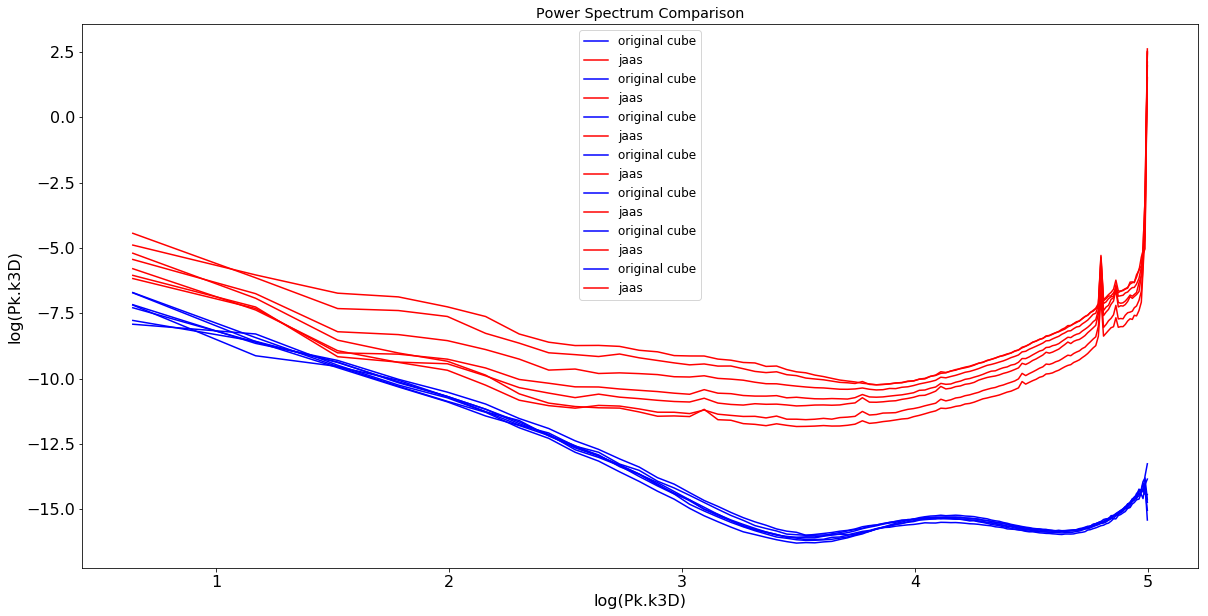

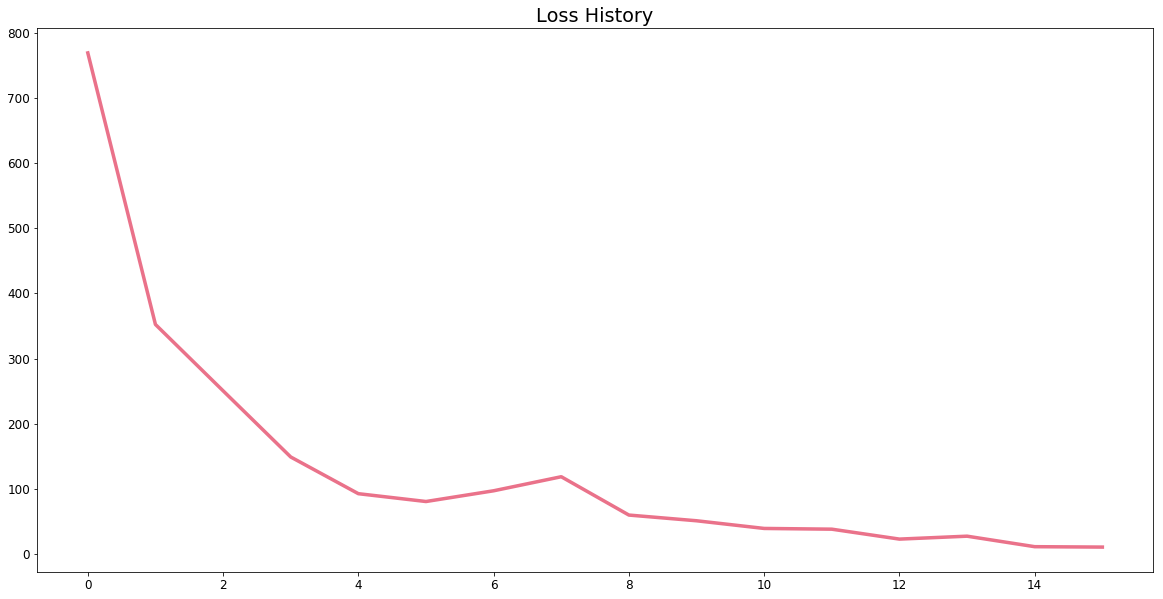

Epoch = 2 / 100
Data transfer to device completed.
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 4131.5317
CONV 1 OUT SUM = -17909.295
RELU 1 OUT SUM = 28716.164
MAX UNPOOL 1 OUT SUM = 28716.162
CONV 2 OUT SUM = 31893.178
RELU 2 OUT SUM = 843699.7
MAX UNPOOL 2 OUT SUM = 843699.9
CONV 3 OUT SUM = -40179.03
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 8251756.5
MSE = tensor(0.0944, grad_fn=<MseLossBackward>)
KLD = tensor(0.3642, grad_fn=<MulBackward>)
Loss = tensor(5.9218, grad_fn=<ThAddBackward>)
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Data transfer to device completed.
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 4074.048
CONV 1 OUT SUM = -18162.887
RELU 1 OUT SUM = 28471.541
MAX UNPOOL 1 OUT SUM = 28471.541
CONV 2 OUT SUM = 37023.42
RELU 2 OUT SUM = 833243.1
MAX UNPOOL 2 OUT SUM = 833243.5
CONV 3 OUT SUM = -73108.17
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU

data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 5258.248
CONV 1 OUT SUM = -26746.012
RELU 1 OUT SUM = 26694.324
MAX UNPOOL 1 OUT SUM = 26694.32
CONV 2 OUT SUM = 68386.445
RELU 2 OUT SUM = 726149.2
MAX UNPOOL 2 OUT SUM = 726150.8
CONV 3 OUT SUM = -268759.06
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 7204159.0
Output mass sum (reconstructed batch): 462280.2
Data transfer to device completed.
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 4862.456
CONV 1 OUT SUM = -24563.52
RELU 1 OUT SUM = 26552.572
MAX UNPOOL 1 OUT SUM = 26552.574
CONV 2 OUT SUM = 67448.88
RELU 2 OUT SUM = 710270.0
MAX UNPOOL 2 OUT SUM = 710272.1
CONV 3 OUT SUM = -250821.84
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 7018333.5
MSE = tensor(0.0398, grad_fn=<MseLossBackward>)
KLD = tensor(0.1696, grad_fn=<MulBackward>)
Loss = tensor(2.7541, grad_f

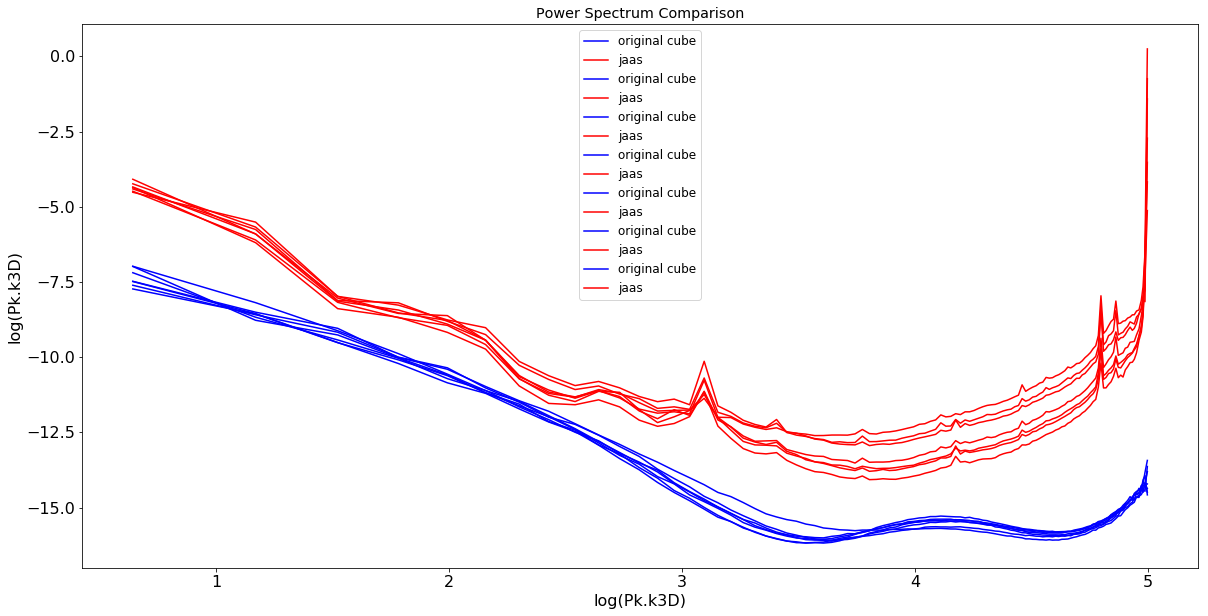

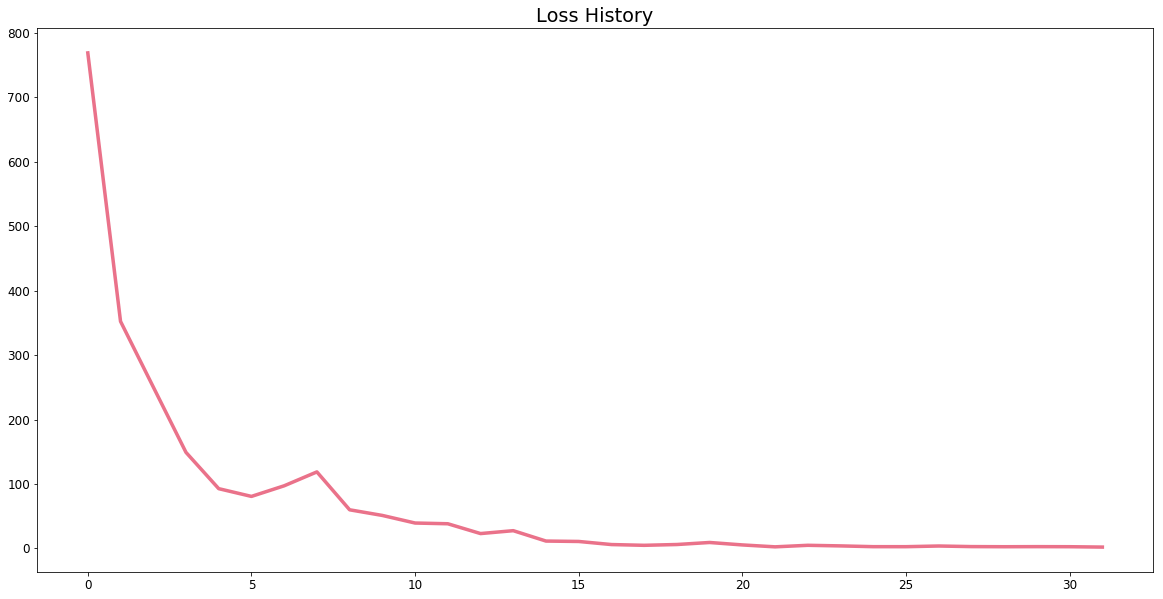

Epoch = 3 / 100
Data transfer to device completed.
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 5152.5693
CONV 1 OUT SUM = -25284.21
RELU 1 OUT SUM = 25354.578
MAX UNPOOL 1 OUT SUM = 25354.572
CONV 2 OUT SUM = 68801.32
RELU 2 OUT SUM = 637191.7
MAX UNPOOL 2 OUT SUM = 637192.3
CONV 3 OUT SUM = -230254.64
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 6214866.0
MSE = tensor(0.0274, grad_fn=<MseLossBackward>)
KLD = tensor(0.1339, grad_fn=<MulBackward>)
Loss = tensor(2.1694, grad_fn=<ThAddBackward>)
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Data transfer to device completed.
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 5128.8174
CONV 1 OUT SUM = -24901.121
RELU 1 OUT SUM = 25495.785
MAX UNPOOL 1 OUT SUM = 25495.775
CONV 2 OUT SUM = 69311.336
RELU 2 OUT SUM = 627129.44
MAX UNPOOL 2 OUT SUM = 627129.2
CONV 3 OUT SUM = -223829.56
decoder out size = torch.Size([16, 1, 128, 128, 128])
R

data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 5603.836
CONV 1 OUT SUM = -22546.662
RELU 1 OUT SUM = 23351.074
MAX UNPOOL 1 OUT SUM = 23351.07
CONV 2 OUT SUM = 62181.84
RELU 2 OUT SUM = 520476.56
MAX UNPOOL 2 OUT SUM = 520477.3
CONV 3 OUT SUM = -164660.2
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 4732631.0
Output mass sum (reconstructed batch): 281522.5
Data transfer to device completed.
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 5761.147
CONV 1 OUT SUM = -23462.262
RELU 1 OUT SUM = 23431.64
MAX UNPOOL 1 OUT SUM = 23431.645
CONV 2 OUT SUM = 62821.164
RELU 2 OUT SUM = 525264.94
MAX UNPOOL 2 OUT SUM = 525264.94
CONV 3 OUT SUM = -169778.14
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 4770416.0
MSE = tensor(0.0124, grad_fn=<MseLossBackward>)
KLD = tensor(0.0494, grad_fn=<MulBackward>)
Loss = tensor(0.8036, grad

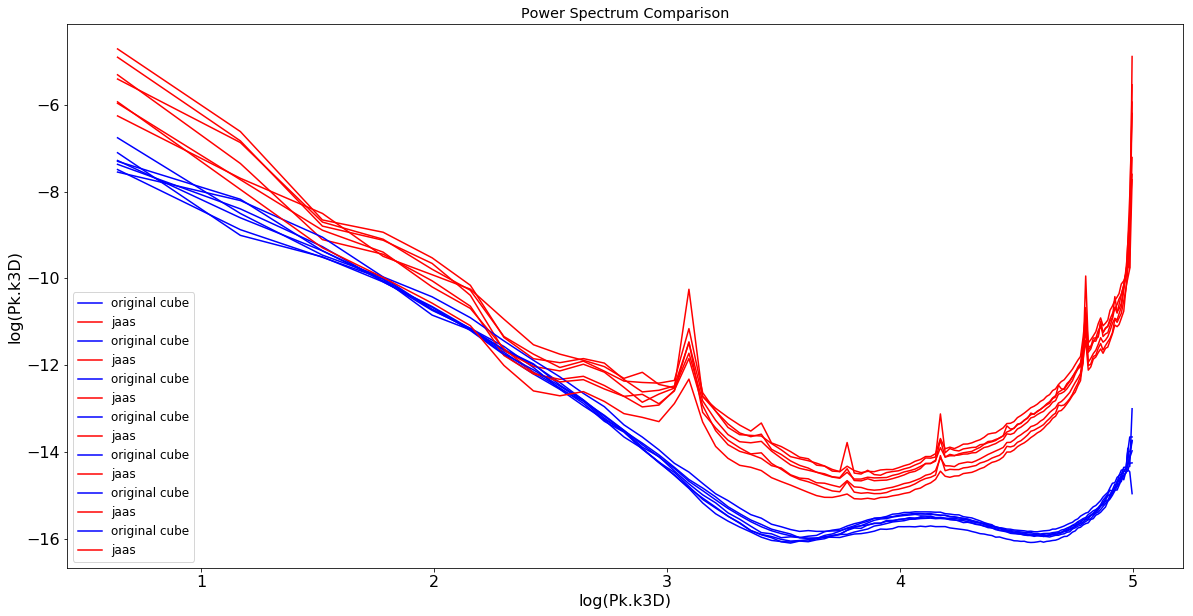

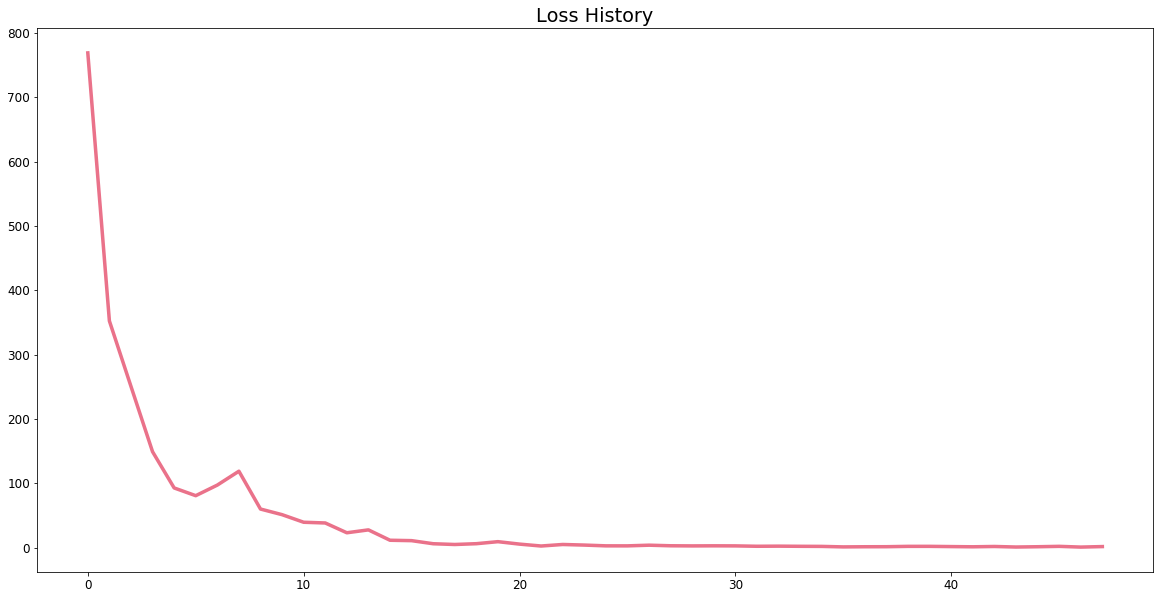

Epoch = 4 / 100
Data transfer to device completed.
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 5768.361
CONV 1 OUT SUM = -20769.768
RELU 1 OUT SUM = 21720.676
MAX UNPOOL 1 OUT SUM = 21720.68
CONV 2 OUT SUM = 56583.98
RELU 2 OUT SUM = 465815.94
MAX UNPOOL 2 OUT SUM = 465816.62
CONV 3 OUT SUM = -193590.83
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 4025209.8
MSE = tensor(0.0087, grad_fn=<MseLossBackward>)
KLD = tensor(0.0381, grad_fn=<MulBackward>)
Loss = tensor(0.6177, grad_fn=<ThAddBackward>)
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Data transfer to device completed.
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 5664.8105
CONV 1 OUT SUM = -19944.555
RELU 1 OUT SUM = 21554.55
MAX UNPOOL 1 OUT SUM = 21554.55
CONV 2 OUT SUM = 55594.8
RELU 2 OUT SUM = 458153.03
MAX UNPOOL 2 OUT SUM = 458152.8
CONV 3 OUT SUM = -209824.67
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU

data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 6034.8687
CONV 1 OUT SUM = -17689.51
RELU 1 OUT SUM = 19582.709
MAX UNPOOL 1 OUT SUM = 19582.71
CONV 2 OUT SUM = 48026.793
RELU 2 OUT SUM = 386293.25
MAX UNPOOL 2 OUT SUM = 386294.0
CONV 3 OUT SUM = -175025.8
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 3069062.8
Output mass sum (reconstructed batch): 200724.19
Data transfer to device completed.
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 5949.671
CONV 1 OUT SUM = -17501.76
RELU 1 OUT SUM = 19362.055
MAX UNPOOL 1 OUT SUM = 19362.055
CONV 2 OUT SUM = 47435.523
RELU 2 OUT SUM = 382611.5
MAX UNPOOL 2 OUT SUM = 382611.72
CONV 3 OUT SUM = -169511.4
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 3009978.8
MSE = tensor(0.0042, grad_fn=<MseLossBackward>)
KLD = tensor(0.0767, grad_fn=<MulBackward>)
Loss = tensor(1.2318, grad

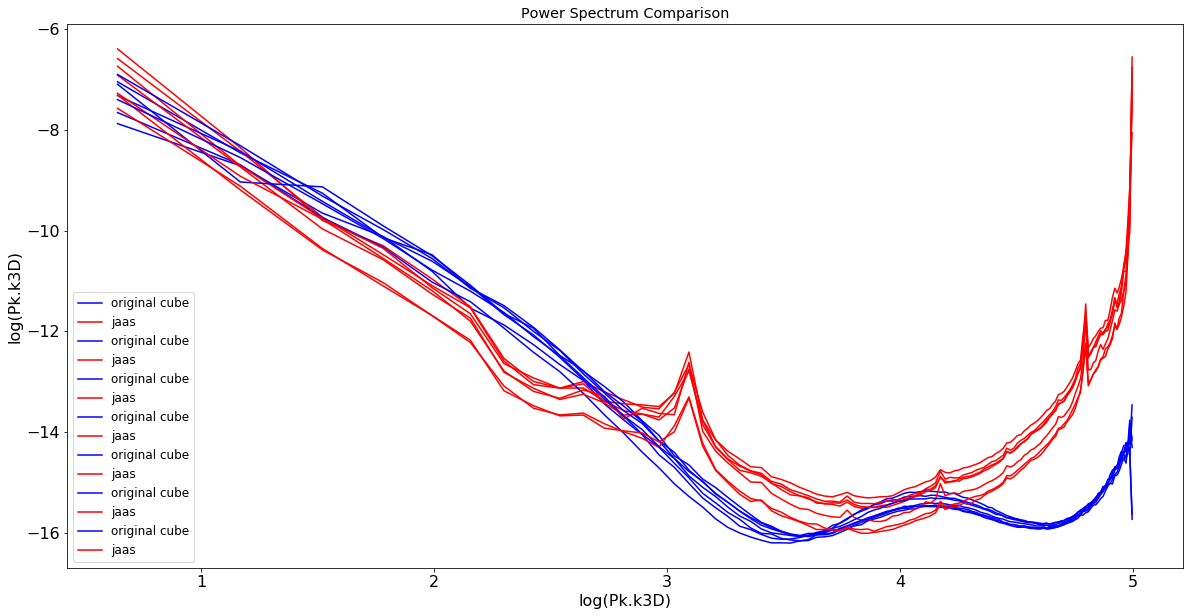

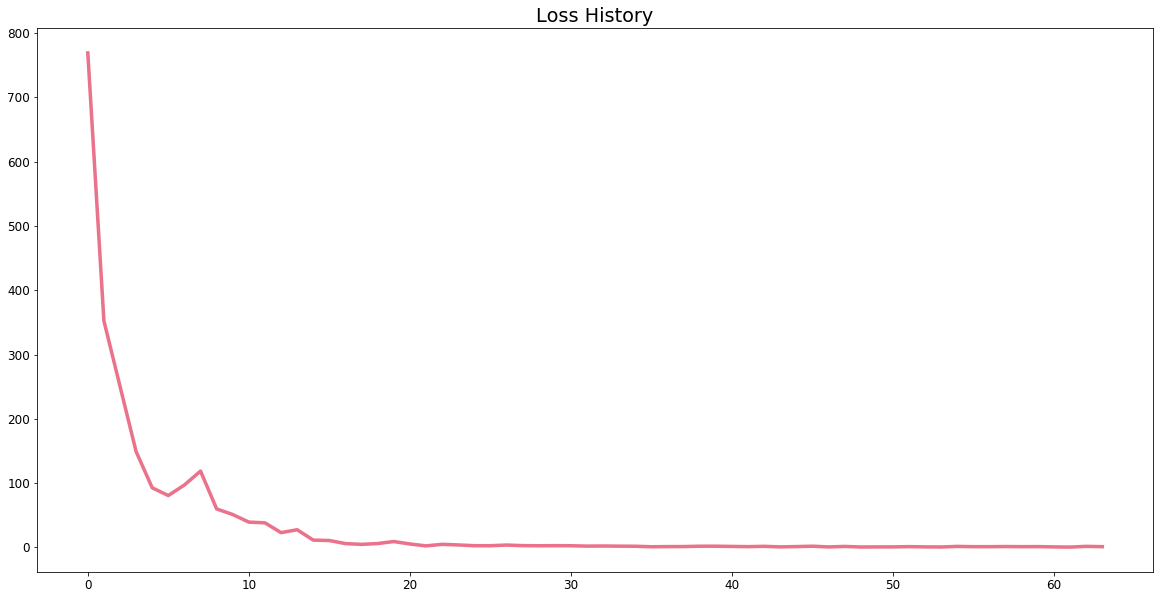

Epoch = 5 / 100
Data transfer to device completed.
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 5822.963
CONV 1 OUT SUM = -15874.5205
RELU 1 OUT SUM = 18384.877
MAX UNPOOL 1 OUT SUM = 18384.877
CONV 2 OUT SUM = 43905.574
RELU 2 OUT SUM = 354190.44
MAX UNPOOL 2 OUT SUM = 354190.53
CONV 3 OUT SUM = -165486.03
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 2679627.0
MSE = tensor(0.0032, grad_fn=<MseLossBackward>)
KLD = tensor(0.0398, grad_fn=<MulBackward>)
Loss = tensor(0.6393, grad_fn=<ThAddBackward>)
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Data transfer to device completed.
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 5727.433
CONV 1 OUT SUM = -15435.249
RELU 1 OUT SUM = 18532.229
MAX UNPOOL 1 OUT SUM = 18532.234
CONV 2 OUT SUM = 44222.477
RELU 2 OUT SUM = 356321.25
MAX UNPOOL 2 OUT SUM = 356322.2
CONV 3 OUT SUM = -174119.45
decoder out size = torch.Size([16, 1, 128, 128, 128]

data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 5927.172
CONV 1 OUT SUM = -14204.09
RELU 1 OUT SUM = 17285.523
MAX UNPOOL 1 OUT SUM = 17285.521
CONV 2 OUT SUM = 39830.316
RELU 2 OUT SUM = 321861.94
MAX UNPOOL 2 OUT SUM = 321861.97
CONV 3 OUT SUM = -155032.66
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 2292875.2
Output mass sum (reconstructed batch): 143948.11
Data transfer to device completed.
Encode - Forward Pass Finished
Starting Decoding
FIRST DECODE OUT SUM = 5688.419
CONV 1 OUT SUM = -13669.798
RELU 1 OUT SUM = 17445.328
MAX UNPOOL 1 OUT SUM = 17445.326
CONV 2 OUT SUM = 40227.24
RELU 2 OUT SUM = 324031.03
MAX UNPOOL 2 OUT SUM = 324031.4
CONV 3 OUT SUM = -156724.83
decoder out size = torch.Size([16, 1, 128, 128, 128])
RELU 3 OUT SUM = 2313052.2
MSE = tensor(0.0026, grad_fn=<MseLossBackward>)
KLD = tensor(0.0239, grad_fn=<MulBackward>)
Loss = tensor(0.3848, g

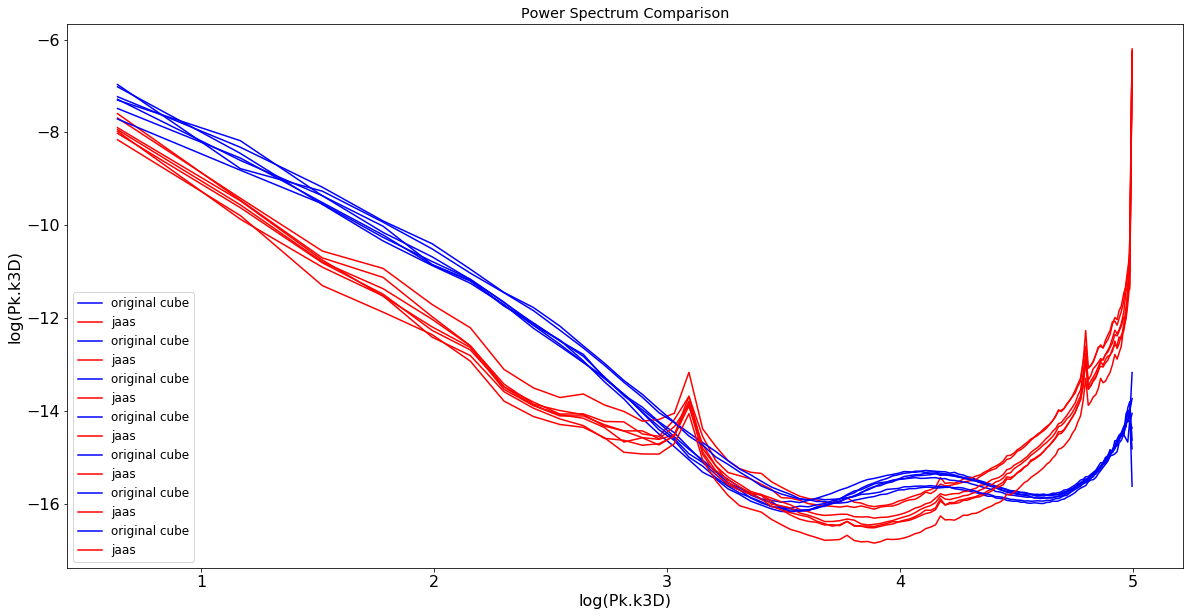

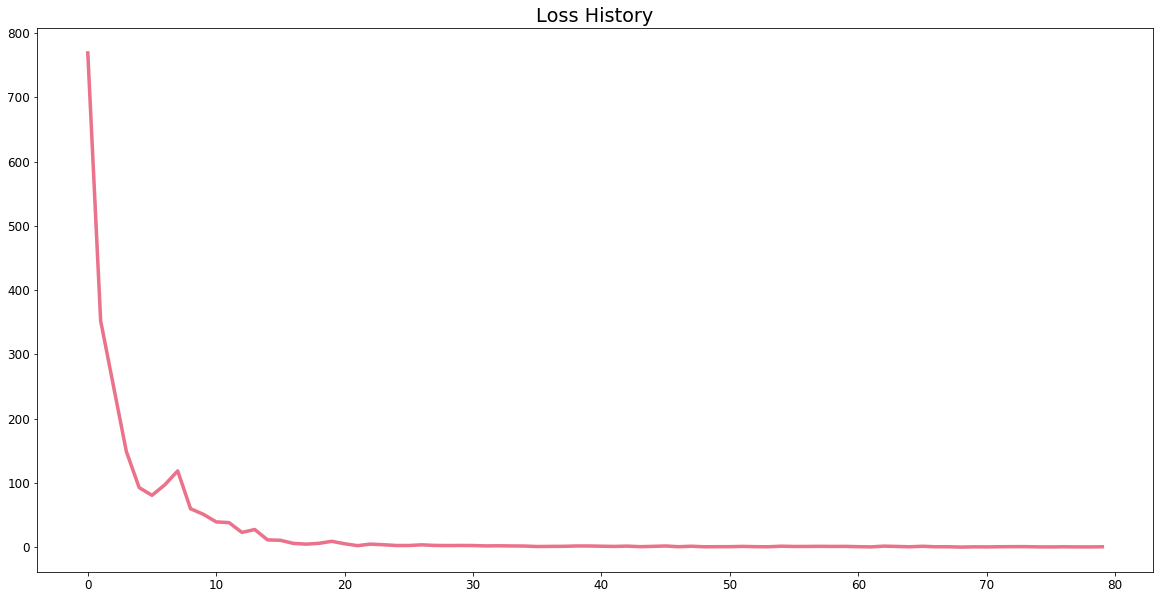

Epoch = 6 / 100
Data transfer to device completed.


In [ ]:
if __name__ == "__main__":
    
    loss_history = []
    
    decoder_sum_lists = {}
        
    for out_plot in ["first_decode_out_sum", "conv_1_out_sum", "relu_1_out_sum", "max_unpool_1_out_sum",
                    "conv_2_out_sum", "relu_2_out_sum", "max_unpool_2_out_sum", "conv_3_out_sum", \
                    "relu_3_out_sum"]:
            
        decoder_sum_lists[out_plot] = []
            
    for epoch in range(1, epochs + 1):
        print("Epoch = " + str(epoch) + " / " + str(epochs))
        
        train(epoch)
        
        # Plotting Training Losses
        plt.figure(figsize=(20,10))
#         plt.ylim(-0.0001,0.7)
        plt.plot(loss_history, linewidth=3.5, alpha=0.6,
                color="crimson")
        plt.rcParams["font.size"] = 16
        plt.title("Loss History")
        plt.show()
        

#         test(epoch)
        
        
#         with torch.no_grad():
#             sample = torch.randn(64, 20).to(device)
#             sample = model.decode(sample).cpu()
#             save_image(sample.view(64, 1, 28, 28),
#                        'results/sample_' + str(epoch) + '.png')